# Machine Type

In [ ]:
!nvidia-smi

Tue May 11 16:54:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mount Colab

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup Environment

In [ ]:
!wget 'https://adl-models.ototot.tk/hw2/dataset.zip' -O dataset.zip
!unzip -o dataset.zip

!pip install accelerate==0.2.1 datasets==1.6.0 torch==1.7.1 spacy==3.0.5 transformers==4.5.0 seqeval==1.2.2 tqdm pytorch-lightning==1.2.3 sentencepiece==0.1.91
!python3 -m spacy download zh_core_web_md

--2021-05-11 16:54:13--  https://adl-models.ototot.tk/hw2/dataset.zip
Resolving adl-models.ototot.tk (adl-models.ototot.tk)... 172.67.149.238, 104.21.63.197, 2606:4700:3035::6815:3fc5, ...
Connecting to adl-models.ototot.tk (adl-models.ototot.tk)|172.67.149.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8586853 (8.2M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]   8.19M  --.-KB/s    in 0.07s   

2021-05-11 16:54:13 (123 MB/s) - ‘dataset.zip’ saved [8586853/8586853]

Archive:  dataset.zip
  inflating: hw2_dataset/dataset/public.json  
  inflating: hw2_dataset/dataset/context.json  
  inflating: hw2_dataset/dataset/train.json  
  inflating: hw2_dataset/dataset/private.json  
  inflating: hw2_dataset/dataset/sample_prediction.json  
  inflating: hw2_dataset/eval.py     
2021-05-11 16:54:18.280713: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

# Transform Dataset

In [ ]:
"""
Transform training data to qa trainable files
"""

import sys

from pathlib import Path
import argparse
import json
from tqdm.notebook import tqdm


def main(args):
    """
    load and transform indata to outdata
    """
    context = json.load(open(args.context))
    indata = json.load(open(args.input))
    res = {'data': []}
    for data in tqdm(indata):
        cur = {
            'question': data['question'],
            'context': context[data["relevant"]],
            'id': data['id']
        }
        if 'answers' in data:
            cur['answers'] = {
                'text': [ans['text'] for ans in data['answers']],
                'answer_start': [ans['start'] for ans in data['answers']]
            }
        res['data'].append(cur)
    json.dump(res, open(args.output, 'w'))


if __name__ == '__main__':
    sys.argv = ['transform_qa.py', '--input', 'hw2_dataset/dataset/public.json', '--context', 'hw2_dataset/dataset/context.json',  '--output', 'public_qa.json']

    parser = argparse.ArgumentParser()

    parser.add_argument('--context', type=Path, help='Context json file')
    parser.add_argument('--input', type=Path, help='Input json file')
    parser.add_argument('--output', type=Path, help='Output json file')

    main(parser.parse_args())

# Prediction basic

In [ ]:
# coding=utf-8
# Copyright 2020 The HuggingFace Team All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
Post-processing utilities for question answering.
"""
import collections
import json
import logging
import os
from typing import Optional, Tuple

import numpy as np
from tqdm.auto import tqdm

logger = logging.getLogger(__name__)


def postprocess_qa_predictions(
    examples,
    features,
    predictions: Tuple[np.ndarray, np.ndarray],
    version_2_with_negative: bool = False,
    n_best_size: int = 20,
    max_answer_length: int = 30,
    null_score_diff_threshold: float = 0.0,
    output_dir: Optional[str] = None,
    prefix: Optional[str] = None,
    is_world_process_zero: bool = True,
):
    """
    Post-processes the predictions of a question-answering model to convert them to answers that are substrings of the
    original contexts. This is the base postprocessing functions for models that only return start and end logits.

    Args:
        examples: The non-preprocessed dataset (see the main script for more information).
        features: The processed dataset (see the main script for more information).
        predictions (:obj:`Tuple[np.ndarray, np.ndarray]`):
            The predictions of the model: two arrays containing the start logits and the end logits respectively. Its
            first dimension must match the number of elements of :obj:`features`.
        version_2_with_negative (:obj:`bool`, `optional`, defaults to :obj:`False`):
            Whether or not the underlying dataset contains examples with no answers.
        n_best_size (:obj:`int`, `optional`, defaults to 20):
            The total number of n-best predictions to generate when looking for an answer.
        max_answer_length (:obj:`int`, `optional`, defaults to 30):
            The maximum length of an answer that can be generated. This is needed because the start and end predictions
            are not conditioned on one another.
        null_score_diff_threshold (:obj:`float`, `optional`, defaults to 0):
            The threshold used to select the null answer: if the best answer has a score that is less than the score of
            the null answer minus this threshold, the null answer is selected for this example (note that the score of
            the null answer for an example giving several features is the minimum of the scores for the null answer on
            each feature: all features must be aligned on the fact they `want` to predict a null answer).

            Only useful when :obj:`version_2_with_negative` is :obj:`True`.
        output_dir (:obj:`str`, `optional`):
            If provided, the dictionaries of predictions, n_best predictions (with their scores and logits) and, if
            :obj:`version_2_with_negative=True`, the dictionary of the scores differences between best and null
            answers, are saved in `output_dir`.
        prefix (:obj:`str`, `optional`):
            If provided, the dictionaries mentioned above are saved with `prefix` added to their names.
        is_world_process_zero (:obj:`bool`, `optional`, defaults to :obj:`True`):
            Whether this process is the main process or not (used to determine if logging/saves should be done).
    """
    assert len(
        predictions
    ) == 2, "`predictions` should be a tuple with two elements (start_logits, end_logits)."
    all_start_logits, all_end_logits = predictions

    assert len(predictions[0]) == len(
        features
    ), f"Got {len(predictions[0])} predictions and {len(features)} features."

    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[
            feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    all_predictions = collections.OrderedDict()
    all_nbest_json = collections.OrderedDict()
    if version_2_with_negative:
        scores_diff_json = collections.OrderedDict()

    # Logging.
    logger.setLevel(logging.INFO if is_world_process_zero else logging.WARN)
    logger.info(
        f"Post-processing {len(examples)} example predictions split into {len(features)} features."
    )

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_prediction = None
        prelim_predictions = []

        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]
            # Optional `token_is_max_context`, if provided we will remove answers that do not have the maximum context
            # available in the current feature.
            token_is_max_context = features[feature_index].get(
                "token_is_max_context", None)

            # Update minimum null prediction.
            feature_null_score = start_logits[0] + end_logits[0]
            if min_null_prediction is None or min_null_prediction[
                    "score"] > feature_null_score:
                min_null_prediction = {
                    "offsets": (0, 0),
                    "score": feature_null_score,
                    "start_logit": start_logits[0],
                    "end_logit": end_logits[0],
                }

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1:-n_best_size -
                                                     1:-1].tolist()
            end_indexes = np.argsort(end_logits)[-1:-n_best_size -
                                                 1:-1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (start_index >= len(offset_mapping)
                            or end_index >= len(offset_mapping)
                            or offset_mapping[start_index] is None
                            or offset_mapping[end_index] is None):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue
                    # Don't consider answer that don't have the maximum context available (if such information is
                    # provided).
                    if token_is_max_context is not None and not token_is_max_context.get(
                            str(start_index), False):
                        continue
                    prelim_predictions.append({
                        "offsets": (offset_mapping[start_index][0],
                                    offset_mapping[end_index][1]),
                        "score":
                        start_logits[start_index] + end_logits[end_index],
                        "start_logit":
                        start_logits[start_index],
                        "end_logit":
                        end_logits[end_index],
                    })
        if version_2_with_negative:
            # Add the minimum null prediction
            prelim_predictions.append(min_null_prediction)
            null_score = min_null_prediction["score"]

        # Only keep the best `n_best_size` predictions.
        predictions = sorted(prelim_predictions,
                             key=lambda x: x["score"],
                             reverse=True)[:n_best_size]

        # Add back the minimum null prediction if it was removed because of its low score.
        if version_2_with_negative and not any(p["offsets"] == (0, 0)
                                               for p in predictions):
            predictions.append(min_null_prediction)

        # Use the offsets to gather the answer text in the original context.
        context = example["context"]
        for pred in predictions:
            offsets = pred.pop("offsets")
            pred["text"] = context[offsets[0]:offsets[1]]

        # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
        # failure.
        if len(predictions) == 0 or (len(predictions) == 1
                                     and predictions[0]["text"] == ""):
            predictions.insert(
                0, {
                    "text": "empty",
                    "start_logit": 0.0,
                    "end_logit": 0.0,
                    "score": 0.0
                })

        # Compute the softmax of all scores (we do it with numpy to stay independent from torch/tf in this file, using
        # the LogSumExp trick).
        scores = np.array([pred.pop("score") for pred in predictions])
        exp_scores = np.exp(scores - np.max(scores))
        probs = exp_scores / exp_scores.sum()

        # Include the probabilities in our predictions.
        for prob, pred in zip(probs, predictions):
            pred["probability"] = prob

        # Pick the best prediction. If the null answer is not possible, this is easy.
        if not version_2_with_negative:
            all_predictions[example["id"]] = predictions[0]["text"]
        else:
            # Otherwise we first need to find the best non-empty prediction.
            i = 0
            while predictions[i]["text"] == "":
                i += 1
            best_non_null_pred = predictions[i]

            # Then we compare to the null prediction using the threshold.
            score_diff = null_score - best_non_null_pred[
                "start_logit"] - best_non_null_pred["end_logit"]
            scores_diff_json[example["id"]] = float(
                score_diff)  # To be JSON-serializable.
            if score_diff > null_score_diff_threshold:
                all_predictions[example["id"]] = ""
            else:
                all_predictions[example["id"]] = best_non_null_pred["text"]

        # Make `predictions` JSON-serializable by casting np.float back to float.
        all_nbest_json[example["id"]] = [{
            k: (float(v) if isinstance(v, (np.float16, np.float32,
                                           np.float64)) else v)
            for k, v in pred.items()
        } for pred in predictions]

    # If we have an output_dir, let's save all those dicts.
    if output_dir is not None:
        assert os.path.isdir(output_dir), f"{output_dir} is not a directory."

        prediction_file = os.path.join(
            output_dir, "predictions.json"
            if prefix is None else f"{prefix}_predictions.json")
        nbest_file = os.path.join(
            output_dir, "nbest_predictions.json"
            if prefix is None else f"{prefix}_nbest_predictions.json")
        if version_2_with_negative:
            null_odds_file = os.path.join(
                output_dir, "null_odds.json"
                if prefix is None else f"{prefix}_null_odds.json")

        logger.info(f"Saving predictions to {prediction_file}.")
        with open(prediction_file, "w") as writer:
            writer.write(json.dumps(all_predictions, indent=4) + "\n")
        logger.info(f"Saving nbest_preds to {nbest_file}.")
        with open(nbest_file, "w") as writer:
            writer.write(json.dumps(all_nbest_json, indent=4) + "\n")
        if version_2_with_negative:
            logger.info(f"Saving null_odds to {null_odds_file}.")
            with open(null_odds_file, "w") as writer:
                writer.write(json.dumps(scores_diff_json, indent=4) + "\n")

    return all_predictions


def postprocess_qa_predictions_with_beam_search(
    examples,
    features,
    predictions: Tuple[np.ndarray, np.ndarray],
    version_2_with_negative: bool = False,
    n_best_size: int = 20,
    max_answer_length: int = 30,
    start_n_top: int = 5,
    end_n_top: int = 5,
    output_dir: Optional[str] = None,
    prefix: Optional[str] = None,
    is_world_process_zero: bool = True,
):
    """
    Post-processes the predictions of a question-answering model with beam search to convert them to answers that are substrings of the
    original contexts. This is the postprocessing functions for models that return start and end logits, indices, as well as
    cls token predictions.

    Args:
        examples: The non-preprocessed dataset (see the main script for more information).
        features: The processed dataset (see the main script for more information).
        predictions (:obj:`Tuple[np.ndarray, np.ndarray]`):
            The predictions of the model: two arrays containing the start logits and the end logits respectively. Its
            first dimension must match the number of elements of :obj:`features`.
        version_2_with_negative (:obj:`bool`, `optional`, defaults to :obj:`False`):
            Whether or not the underlying dataset contains examples with no answers.
        n_best_size (:obj:`int`, `optional`, defaults to 20):
            The total number of n-best predictions to generate when looking for an answer.
        max_answer_length (:obj:`int`, `optional`, defaults to 30):
            The maximum length of an answer that can be generated. This is needed because the start and end predictions
            are not conditioned on one another.
        start_n_top (:obj:`int`, `optional`, defaults to 5):
            The number of top start logits too keep when searching for the :obj:`n_best_size` predictions.
        end_n_top (:obj:`int`, `optional`, defaults to 5):
            The number of top end logits too keep when searching for the :obj:`n_best_size` predictions.
        output_dir (:obj:`str`, `optional`):
            If provided, the dictionaries of predictions, n_best predictions (with their scores and logits) and, if
            :obj:`version_2_with_negative=True`, the dictionary of the scores differences between best and null
            answers, are saved in `output_dir`.
        prefix (:obj:`str`, `optional`):
            If provided, the dictionaries mentioned above are saved with `prefix` added to their names.
        is_world_process_zero (:obj:`bool`, `optional`, defaults to :obj:`True`):
            Whether this process is the main process or not (used to determine if logging/saves should be done).
    """
    assert len(predictions
               ) == 5, "`predictions` should be a tuple with five elements."
    start_top_log_probs, start_top_index, end_top_log_probs, end_top_index, cls_logits = predictions

    assert len(predictions[0]) == len(
        features
    ), f"Got {len(predictions[0])} predicitions and {len(features)} features."

    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[
            feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    all_predictions = collections.OrderedDict()
    all_nbest_json = collections.OrderedDict()
    scores_diff_json = collections.OrderedDict(
    ) if version_2_with_negative else None

    # Logging.
    logger.setLevel(logging.INFO if is_world_process_zero else logging.WARN)
    logger.info(
        f"Post-processing {len(examples)} example predictions split into {len(features)} features."
    )

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None
        prelim_predictions = []

        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_log_prob = start_top_log_probs[feature_index]
            start_indexes = start_top_index[feature_index]
            end_log_prob = end_top_log_probs[feature_index]
            end_indexes = end_top_index[feature_index]
            feature_null_score = cls_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]
            # Optional `token_is_max_context`, if provided we will remove answers that do not have the maximum context
            # available in the current feature.
            token_is_max_context = features[feature_index].get(
                "token_is_max_context", None)

            # Update minimum null prediction
            if min_null_score is None or feature_null_score < min_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_start_top`/`n_end_top` greater start and end logits.
            for i in range(start_n_top):
                for j in range(end_n_top):
                    start_index = start_indexes[i]
                    j_index = i * end_n_top + j
                    end_index = end_indexes[j_index]
                    # Don't consider out-of-scope answers (last part of the test should be unnecessary because of the
                    # p_mask but let's not take any risk)
                    if (start_index >= len(offset_mapping)
                            or end_index >= len(offset_mapping)
                            or offset_mapping[start_index] is None
                            or offset_mapping[end_index] is None):
                        continue
                    # Don't consider answers with a length negative or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue
                    # Don't consider answer that don't have the maximum context available (if such information is
                    # provided).
                    if token_is_max_context is not None and not token_is_max_context.get(
                            str(start_index), False):
                        continue
                    prelim_predictions.append({
                        "offsets": (offset_mapping[start_index][0],
                                    offset_mapping[end_index][1]),
                        "score":
                        start_log_prob[i] + end_log_prob[j_index],
                        "start_log_prob":
                        start_log_prob[i],
                        "end_log_prob":
                        end_log_prob[j_index],
                    })

        # Only keep the best `n_best_size` predictions.
        predictions = sorted(prelim_predictions,
                             key=lambda x: x["score"],
                             reverse=True)[:n_best_size]

        # Use the offsets to gather the answer text in the original context.
        context = example["context"]
        for pred in predictions:
            offsets = pred.pop("offsets")
            pred["text"] = context[offsets[0]:offsets[1]]

        # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
        # failure.
        if len(predictions) == 0:
            predictions.insert(
                0, {
                    "text": "",
                    "start_logit": -1e-6,
                    "end_logit": -1e-6,
                    "score": -2e-6
                })

        # Compute the softmax of all scores (we do it with numpy to stay independent from torch/tf in this file, using
        # the LogSumExp trick).
        scores = np.array([pred.pop("score") for pred in predictions])
        exp_scores = np.exp(scores - np.max(scores))
        probs = exp_scores / exp_scores.sum()

        # Include the probabilities in our predictions.
        for prob, pred in zip(probs, predictions):
            pred["probability"] = prob

        # Pick the best prediction and set the probability for the null answer.
        all_predictions[example["id"]] = predictions[0]["text"]
        if version_2_with_negative:
            scores_diff_json[example["id"]] = float(min_null_score)

        # Make `predictions` JSON-serializable by casting np.float back to float.
        all_nbest_json[example["id"]] = [{
            k: (float(v) if isinstance(v, (np.float16, np.float32,
                                           np.float64)) else v)
            for k, v in pred.items()
        } for pred in predictions]

    # If we have an output_dir, let's save all those dicts.
    if output_dir is not None:
        assert os.path.isdir(output_dir), f"{output_dir} is not a directory."

        prediction_file = os.path.join(
            output_dir, "predictions.json"
            if prefix is None else f"{prefix}_predictions.json")
        nbest_file = os.path.join(
            output_dir, "nbest_predictions.json"
            if prefix is None else f"{prefix}_nbest_predictions.json")
        if version_2_with_negative:
            null_odds_file = os.path.join(
                output_dir, "null_odds.json"
                if prefix is None else f"{prefix}_null_odds.json")

        print(f"Saving predictions to {prediction_file}.")
        with open(prediction_file, "w") as writer:
            writer.write(json.dumps(all_predictions, indent=4) + "\n")
        print(f"Saving nbest_preds to {nbest_file}.")
        with open(nbest_file, "w") as writer:
            writer.write(json.dumps(all_nbest_json, indent=4) + "\n")
        if version_2_with_negative:
            print(f"Saving null_odds to {null_odds_file}.")
            with open(null_odds_file, "w") as writer:
                writer.write(json.dumps(scores_diff_json, indent=4) + "\n")

    return all_predictions, scores_diff_json


# coding=utf-8
# Copyright 2020 The HuggingFace Team All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
A subclass of `Trainer` specific to Question-Answering tasks
"""

from transformers import Trainer, is_datasets_available, is_torch_tpu_available
from transformers.trainer_utils import PredictionOutput

if is_datasets_available():
    import datasets

if is_torch_tpu_available():
    import torch_xla.core.xla_model as xm
    import torch_xla.debug.metrics as met


class QuestionAnsweringTrainer(Trainer):
    def __init__(self,
                 *args,
                 eval_examples=None,
                 post_process_function=None,
                 **kwargs):
        super().__init__(*args, **kwargs)
        self.eval_examples = eval_examples
        self.post_process_function = post_process_function

    def evaluate(self,
                 eval_dataset=None,
                 eval_examples=None,
                 ignore_keys=None):
        eval_dataset = self.eval_dataset if eval_dataset is None else eval_dataset
        eval_dataloader = self.get_eval_dataloader(eval_dataset)
        eval_examples = self.eval_examples if eval_examples is None else eval_examples

        # Temporarily disable metric computation, we will do it in the loop here.
        compute_metrics = self.compute_metrics
        self.compute_metrics = None
        try:
            output = self.prediction_loop(
                eval_dataloader,
                description="Evaluation",
                # No point gathering the predictions if there are no metrics, otherwise we defer to
                # self.args.prediction_loss_only
                prediction_loss_only=True if compute_metrics is None else None,
                ignore_keys=ignore_keys,
            )
        finally:
            self.compute_metrics = compute_metrics

        # We might have removed columns from the dataset so we put them back.
        if isinstance(eval_dataset, datasets.Dataset):
            eval_dataset.set_format(type=eval_dataset.format["type"],
                                    columns=list(eval_dataset.features.keys()))

        if self.post_process_function is not None and self.compute_metrics is not None:
            eval_preds = self.post_process_function(eval_examples,
                                                    eval_dataset,
                                                    output.predictions)
            metrics = self.compute_metrics(eval_preds)

            self.log(metrics)
        else:
            metrics = {}

        if self.args.tpu_metrics_debug or self.args.debug:
            # tpu-comment: Logging debug metrics for PyTorch/XLA (compile, execute times, ops, etc.)
            xm.master_print(met.metrics_report())

        self.control = self.callback_handler.on_evaluate(
            self.args, self.state, self.control, metrics)
        return metrics

    def predict(self, test_dataset, test_examples, ignore_keys=None):
        test_dataloader = self.get_test_dataloader(test_dataset)

        # Temporarily disable metric computation, we will do it in the loop here.
        compute_metrics = self.compute_metrics
        self.compute_metrics = None
        try:
            output = self.prediction_loop(
                test_dataloader,
                description="Evaluation",
                # No point gathering the predictions if there are no metrics, otherwise we defer to
                # self.args.prediction_loss_only
                prediction_loss_only=True if compute_metrics is None else None,
                ignore_keys=ignore_keys,
            )
        finally:
            self.compute_metrics = compute_metrics

        if self.post_process_function is None or self.compute_metrics is None:
            return output

        # We might have removed columns from the dataset so we put them back.
        if isinstance(test_dataset, datasets.Dataset):
            test_dataset.set_format(type=test_dataset.format["type"],
                                    columns=list(test_dataset.features.keys()))

        eval_preds = self.post_process_function(test_examples, test_dataset,
                                                output.predictions, "test")
        metrics = self.compute_metrics(eval_preds)

        return PredictionOutput(predictions=eval_preds.predictions,
                                label_ids=eval_preds.label_ids,
                                metrics=metrics)

#!/usr/bin/env python
# coding=utf-8
# Copyright 2020 The HuggingFace Team All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
Fine-tuning the library models for question answering.
"""
# You can also adapt this script on your own question answering task. Pointers for this are left as comments.

import logging
import os
import sys
from dataclasses import dataclass, field
from typing import Optional

from datasets import load_dataset, load_metric

import transformers
from transformers import (
    AutoConfig,
    AutoModelForQuestionAnswering,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    PreTrainedTokenizerFast,
    TrainingArguments,
    default_data_collator,
    set_seed,
)
from transformers.trainer_utils import get_last_checkpoint, is_main_process
from transformers.utils import check_min_version

# Will error if the minimal version of Transformers is not installed. Remove at your own risks.
check_min_version("4.5.0")

logger = logging.getLogger(__name__)


@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune from.
    """

    model_name_or_path: str = field(
        metadata={
            "help":
            "Path to pretrained model or model identifier from huggingface.co/models"
        })
    config_name: Optional[str] = field(
        default=None,
        metadata={
            "help":
            "Pretrained config name or path if not the same as model_name"
        })
    tokenizer_name: Optional[str] = field(
        default=None,
        metadata={
            "help":
            "Pretrained tokenizer name or path if not the same as model_name"
        })
    cache_dir: Optional[str] = field(
        default=None,
        metadata={
            "help":
            "Path to directory to store the pretrained models downloaded from huggingface.co"
        },
    )
    model_revision: str = field(
        default="main",
        metadata={
            "help":
            "The specific model version to use (can be a branch name, tag name or commit id)."
        },
    )
    use_auth_token: bool = field(
        default=False,
        metadata={
            "help":
            "Will use the token generated when running `transformers-cli login` (necessary to use this script "
            "with private models)."
        },
    )


@dataclass
class DataTrainingArguments:
    """
    Arguments pertaining to what data we are going to input our model for training and eval.
    """

    dataset_name: Optional[str] = field(
        default=None,
        metadata={
            "help":
            "The name of the dataset to use (via the datasets library)."
        })
    dataset_config_name: Optional[str] = field(
        default=None,
        metadata={
            "help":
            "The configuration name of the dataset to use (via the datasets library)."
        })
    train_file: Optional[str] = field(
        default=None,
        metadata={"help": "The input training data file (a text file)."})
    validation_file: Optional[str] = field(
        default=None,
        metadata={
            "help":
            "An optional input evaluation data file to evaluate the perplexity on (a text file)."
        },
    )
    test_file: Optional[str] = field(
        default=None,
        metadata={
            "help":
            "An optional input test data file to evaluate the perplexity on (a text file)."
        },
    )
    overwrite_cache: bool = field(
        default=False,
        metadata={"help": "Overwrite the cached training and evaluation sets"})
    preprocessing_num_workers: Optional[int] = field(
        default=None,
        metadata={
            "help": "The number of processes to use for the preprocessing."
        },
    )
    max_seq_length: int = field(
        default=384,
        metadata={
            "help":
            "The maximum total input sequence length after tokenization. Sequences longer "
            "than this will be truncated, sequences shorter will be padded."
        },
    )
    pad_to_max_length: bool = field(
        default=True,
        metadata={
            "help":
            "Whether to pad all samples to `max_seq_length`. "
            "If False, will pad the samples dynamically when batching to the maximum length in the batch (which can "
            "be faster on GPU but will be slower on TPU)."
        },
    )
    max_train_samples: Optional[int] = field(
        default=None,
        metadata={
            "help":
            "For debugging purposes or quicker training, truncate the number of training examples to this "
            "value if set."
        },
    )
    max_val_samples: Optional[int] = field(
        default=None,
        metadata={
            "help":
            "For debugging purposes or quicker training, truncate the number of validation examples to this "
            "value if set."
        },
    )
    max_test_samples: Optional[int] = field(
        default=None,
        metadata={
            "help":
            "For debugging purposes or quicker training, truncate the number of test examples to this "
            "value if set."
        },
    )
    version_2_with_negative: bool = field(
        default=False,
        metadata={
            "help": "If true, some of the examples do not have an answer."
        })
    null_score_diff_threshold: float = field(
        default=0.0,
        metadata={
            "help":
            "The threshold used to select the null answer: if the best answer has a score that is less than "
            "the score of the null answer minus this threshold, the null answer is selected for this example. "
            "Only useful when `version_2_with_negative=True`."
        },
    )
    doc_stride: int = field(
        default=128,
        metadata={
            "help":
            "When splitting up a long document into chunks, how much stride to take between chunks."
        },
    )
    n_best_size: int = field(
        default=20,
        metadata={
            "help":
            "The total number of n-best predictions to generate when looking for an answer."
        },
    )
    max_answer_length: int = field(
        default=30,
        metadata={
            "help":
            "The maximum length of an answer that can be generated. This is needed because the start "
            "and end predictions are not conditioned on one another."
        },
    )

    def __post_init__(self):
        if (self.dataset_name is None and self.train_file is None
                and self.validation_file is None and self.test_file is None):
            raise ValueError(
                "Need either a dataset name or a training/validation file/test_file."
            )
        else:
            if self.train_file is not None:
                extension = self.train_file.split(".")[-1]
                assert extension in [
                    "csv", "json"
                ], "`train_file` should be a csv or a json file."
            if self.validation_file is not None:
                extension = self.validation_file.split(".")[-1]
                assert extension in [
                    "csv", "json"
                ], "`validation_file` should be a csv or a json file."
            if self.test_file is not None:
                extension = self.test_file.split(".")[-1]
                assert extension in [
                    "csv", "json"
                ], "`test_file` should be a csv or a json file."


def main():
    # See all possible arguments in src/transformers/training_args.py
    # or by passing the --help flag to this script.
    # We now keep distinct sets of args, for a cleaner separation of concerns.

    parser = HfArgumentParser(
        (ModelArguments, DataTrainingArguments, TrainingArguments))
    if len(sys.argv) == 2 and sys.argv[1].endswith(".json"):
        # If we pass only one argument to the script and it's the path to a json file,
        # let's parse it to get our arguments.
        model_args, data_args, training_args = parser.parse_json_file(
            json_file=os.path.abspath(sys.argv[1]))
    else:
        model_args, data_args, training_args = parser.parse_args_into_dataclasses(
        )

    # Detecting last checkpoint.
    last_checkpoint = None
    if os.path.isdir(
            training_args.output_dir
    ) and training_args.do_train and not training_args.overwrite_output_dir:
        last_checkpoint = get_last_checkpoint(training_args.output_dir)
        if last_checkpoint is None and len(os.listdir(
                training_args.output_dir)) > 0:
            raise ValueError(
                f"Output directory ({training_args.output_dir}) already exists and is not empty. "
                "Use --overwrite_output_dir to overcome.")
        elif last_checkpoint is not None:
            logger.info(
                f"Checkpoint detected, resuming training at {last_checkpoint}. To avoid this behavior, change "
                "the `--output_dir` or add `--overwrite_output_dir` to train from scratch."
            )

    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        handlers=[logging.StreamHandler(sys.stdout)],
    )
    logger.setLevel(logging.INFO if is_main_process(training_args.local_rank
                                                    ) else logging.WARN)

    # Log on each process the small summary:
    logger.warning(
        f"Process rank: {training_args.local_rank}, device: {training_args.device}, n_gpu: {training_args.n_gpu}"
        +
        f"distributed training: {bool(training_args.local_rank != -1)}, 16-bits training: {training_args.fp16}"
    )
    # Set the verbosity to info of the Transformers logger (on main process only):
    if is_main_process(training_args.local_rank):
        transformers.utils.logging.set_verbosity_info()
        transformers.utils.logging.enable_default_handler()
        transformers.utils.logging.enable_explicit_format()
    logger.info(f"Training/evaluation parameters {training_args}")

    # Set seed before initializing model.
    set_seed(training_args.seed)

    # Get the datasets: you can either provide your own CSV/JSON/TXT training and evaluation files (see below)
    # or just provide the name of one of the public datasets available on the hub at https://huggingface.co/datasets/
    # (the dataset will be downloaded automatically from the datasets Hub).
    #
    # For CSV/JSON files, this script will use the column called 'text' or the first column if no column called
    # 'text' is found. You can easily tweak this behavior (see below).
    #
    # In distributed training, the load_dataset function guarantee that only one local process can concurrently
    # download the dataset.
    if data_args.dataset_name is not None:
        # Downloading and loading a dataset from the hub.
        datasets = load_dataset(data_args.dataset_name,
                                data_args.dataset_config_name)
    else:
        data_files = {}
        if data_args.train_file is not None:
            data_files["train"] = data_args.train_file
            extension = data_args.train_file.split(".")[-1]

        if data_args.validation_file is not None:
            data_files["validation"] = data_args.validation_file
            extension = data_args.validation_file.split(".")[-1]
        if data_args.test_file is not None:
            data_files["test"] = data_args.test_file
            extension = data_args.test_file.split(".")[-1]
        datasets = load_dataset(extension, data_files=data_files, field="data")
    # See more about loading any type of standard or custom dataset (from files, python dict, pandas DataFrame, etc) at
    # https://huggingface.co/docs/datasets/loading_datasets.html.

    # Load pretrained model and tokenizer
    #
    # Distributed training:
    # The .from_pretrained methods guarantee that only one local process can concurrently
    # download model & vocab.
    config = AutoConfig.from_pretrained(
        model_args.config_name
        if model_args.config_name else model_args.model_name_or_path,
        cache_dir=model_args.cache_dir,
        revision=model_args.model_revision,
        use_auth_token=True if model_args.use_auth_token else None,
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_args.tokenizer_name
        if model_args.tokenizer_name else model_args.model_name_or_path,
        cache_dir=model_args.cache_dir,
        use_fast=True,
        revision=model_args.model_revision,
        use_auth_token=True if model_args.use_auth_token else None,
    )
    model = AutoModelForQuestionAnswering.from_pretrained(
        model_args.model_name_or_path,
        from_tf=bool(".ckpt" in model_args.model_name_or_path),
        config=config,
        cache_dir=model_args.cache_dir,
        revision=model_args.model_revision,
        use_auth_token=True if model_args.use_auth_token else None,
    )

    # Tokenizer check: this script requires a fast tokenizer.
    if not isinstance(tokenizer, PreTrainedTokenizerFast):
        raise ValueError(
            "This example script only works for models that have a fast tokenizer. Checkout the big table of models "
            "at https://huggingface.co/transformers/index.html#bigtable to find the model types that meet this "
            "requirement")

    # Preprocessing the datasets.
    # Preprocessing is slighlty different for training and evaluation.
    if training_args.do_train:
        column_names = datasets["train"].column_names
    elif training_args.do_eval:
        column_names = datasets["validation"].column_names
    else:
        column_names = datasets["test"].column_names
    question_column_name = "question" if "question" in column_names else column_names[
        0]
    context_column_name = "context" if "context" in column_names else column_names[
        1]
    answer_column_name = "answers" if "answers" in column_names else column_names[
        2]

    # Padding side determines if we do (question|context) or (context|question).
    pad_on_right = tokenizer.padding_side == "right"

    if data_args.max_seq_length > tokenizer.model_max_length:
        logger.warn(
            f"The max_seq_length passed ({data_args.max_seq_length}) is larger than the maximum length for the"
            f"model ({tokenizer.model_max_length}). Using max_seq_length={tokenizer.model_max_length}."
        )
    max_seq_length = min(data_args.max_seq_length, tokenizer.model_max_length)

    # Training preprocessing
    def prepare_train_features(examples):
        # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
        # in one example possible giving several features when a context is long, each of those features having a
        # context that overlaps a bit the context of the previous feature.
        tokenized_examples = tokenizer(
            examples[
                question_column_name if pad_on_right else context_column_name],
            examples[
                context_column_name if pad_on_right else question_column_name],
            truncation="only_second" if pad_on_right else "only_first",
            max_length=max_seq_length,
            stride=data_args.doc_stride,
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            padding="max_length" if data_args.pad_to_max_length else False,
        )

        # Since one example might give us several features if it has a long context, we need a map from a feature to
        # its corresponding example. This key gives us just that.
        sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
        # The offset mappings will give us a map from token to character position in the original context. This will
        # help us compute the start_positions and end_positions.
        offset_mapping = tokenized_examples.pop("offset_mapping")

        # Let's label those examples!
        tokenized_examples["start_positions"] = []
        tokenized_examples["end_positions"] = []

        for i, offsets in enumerate(offset_mapping):
            # We will label impossible answers with the index of the CLS token.
            input_ids = tokenized_examples["input_ids"][i]
            cls_index = input_ids.index(tokenizer.cls_token_id)

            # Grab the sequence corresponding to that example (to know what is the context and what is the question).
            sequence_ids = tokenized_examples.sequence_ids(i)

            # One example can give several spans, this is the index of the example containing this span of text.
            sample_index = sample_mapping[i]
            answers = examples[answer_column_name][sample_index]
            # If no answers are given, set the cls_index as answer.
            if len(answers["answer_start"]) == 0:
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Start/end character index of the answer in the text.
                start_char = answers["answer_start"][0]
                end_char = start_char + len(answers["text"][0])

                # Start token index of the current span in the text.
                token_start_index = 0
                while sequence_ids[token_start_index] != (1 if pad_on_right
                                                          else 0):
                    token_start_index += 1

                # End token index of the current span in the text.
                token_end_index = len(input_ids) - 1
                while sequence_ids[token_end_index] != (1 if pad_on_right else
                                                        0):
                    token_end_index -= 1

                # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
                if not (offsets[token_start_index][0] <= start_char
                        and offsets[token_end_index][1] >= end_char):
                    tokenized_examples["start_positions"].append(cls_index)
                    tokenized_examples["end_positions"].append(cls_index)
                else:
                    # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                    # Note: we could go after the last offset if the answer is the last word (edge case).
                    while token_start_index < len(offsets) and offsets[
                            token_start_index][0] <= start_char:
                        token_start_index += 1
                    tokenized_examples["start_positions"].append(
                        token_start_index - 1)
                    while offsets[token_end_index][1] >= end_char:
                        token_end_index -= 1
                    tokenized_examples["end_positions"].append(
                        token_end_index + 1)

        return tokenized_examples

    if training_args.do_train:
        if "train" not in datasets:
            raise ValueError("--do_train requires a train dataset")
        train_dataset = datasets["train"]
        if data_args.max_train_samples is not None:
            # We will select sample from whole data if agument is specified
            train_dataset = train_dataset.select(
                range(data_args.max_train_samples))
        # Create train feature from dataset
        train_dataset = train_dataset.map(
            prepare_train_features,
            batched=True,
            num_proc=data_args.preprocessing_num_workers,
            remove_columns=column_names,
            load_from_cache_file=not data_args.overwrite_cache,
        )
        if data_args.max_train_samples is not None:
            # Number of samples might increase during Feature Creation, We select only specified max samples
            train_dataset = train_dataset.select(
                range(data_args.max_train_samples))

    # Validation preprocessing
    def prepare_validation_features(examples):
        # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
        # in one example possible giving several features when a context is long, each of those features having a
        # context that overlaps a bit the context of the previous feature.
        tokenized_examples = tokenizer(
            examples[
                question_column_name if pad_on_right else context_column_name],
            examples[
                context_column_name if pad_on_right else question_column_name],
            truncation="only_second" if pad_on_right else "only_first",
            max_length=max_seq_length,
            stride=data_args.doc_stride,
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            padding="max_length" if data_args.pad_to_max_length else False,
        )

        # Since one example might give us several features if it has a long context, we need a map from a feature to
        # its corresponding example. This key gives us just that.
        sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

        # For evaluation, we will need to convert our predictions to substrings of the context, so we keep the
        # corresponding example_id and we will store the offset mappings.
        tokenized_examples["example_id"] = []

        for i in range(len(tokenized_examples["input_ids"])):
            # Grab the sequence corresponding to that example (to know what is the context and what is the question).
            sequence_ids = tokenized_examples.sequence_ids(i)
            context_index = 1 if pad_on_right else 0

            # One example can give several spans, this is the index of the example containing this span of text.
            sample_index = sample_mapping[i]
            tokenized_examples["example_id"].append(
                examples["id"][sample_index])

            # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
            # position is part of the context or not.
            tokenized_examples["offset_mapping"][i] = [
                (o if sequence_ids[k] == context_index else None)
                for k, o in enumerate(tokenized_examples["offset_mapping"][i])
            ]

        return tokenized_examples

    if training_args.do_eval:
        if "validation" not in datasets:
            raise ValueError("--do_eval requires a validation dataset")
        eval_examples = datasets["validation"]
        if data_args.max_val_samples is not None:
            # We will select sample from whole data
            eval_examples = eval_examples.select(
                range(data_args.max_val_samples))
        # Validation Feature Creation
        eval_dataset = eval_examples.map(
            prepare_validation_features,
            batched=True,
            num_proc=data_args.preprocessing_num_workers,
            remove_columns=column_names,
            load_from_cache_file=not data_args.overwrite_cache,
        )
        if data_args.max_val_samples is not None:
            # During Feature creation dataset samples might increase, we will select required samples again
            eval_dataset = eval_dataset.select(range(
                data_args.max_val_samples))

    if training_args.do_predict:
        if "test" not in datasets:
            raise ValueError("--do_predict requires a test dataset")
        test_examples = datasets["test"]
        if data_args.max_test_samples is not None:
            # We will select sample from whole data
            test_examples = test_examples.select(
                range(data_args.max_test_samples))
        # Test Feature Creation
        test_dataset = test_examples.map(
            prepare_validation_features,
            batched=True,
            num_proc=data_args.preprocessing_num_workers,
            remove_columns=column_names,
            load_from_cache_file=not data_args.overwrite_cache,
        )
        if data_args.max_test_samples is not None:
            # During Feature creation dataset samples might increase, we will select required samples again
            test_dataset = test_dataset.select(
                range(data_args.max_test_samples))

    # Data collator
    # We have already padded to max length if the corresponding flag is True, otherwise we need to pad in the data
    # collator.
    data_collator = (default_data_collator if data_args.pad_to_max_length else
                     DataCollatorWithPadding(
                         tokenizer,
                         pad_to_multiple_of=8 if training_args.fp16 else None))

    # Post-processing:
    def post_processing_function(examples,
                                 features,
                                 predictions,
                                 stage="eval"):
        # Post-processing: we match the start logits and end logits to answers in the original context.
        predictions = postprocess_qa_predictions(
            examples=examples,
            features=features,
            predictions=predictions,
            version_2_with_negative=data_args.version_2_with_negative,
            n_best_size=data_args.n_best_size,
            max_answer_length=data_args.max_answer_length,
            null_score_diff_threshold=data_args.null_score_diff_threshold,
            output_dir=training_args.output_dir,
            is_world_process_zero=trainer.is_world_process_zero(),
            prefix=stage,
        )
        # Format the result to the format the metric expects.
        if data_args.version_2_with_negative:
            formatted_predictions = [{
                "id": k,
                "prediction_text": v,
                "no_answer_probability": 0.0
            } for k, v in predictions.items()]
        else:
            formatted_predictions = [{
                "id": k,
                "prediction_text": v
            } for k, v in predictions.items()]

        references = [{
            "id": ex["id"],
            "answers": ex[answer_column_name]
        } for ex in examples]
        return EvalPrediction(predictions=formatted_predictions,
                              label_ids=references)

    metric = load_metric(
        "squad_v2" if data_args.version_2_with_negative else "squad")

    def compute_metrics(p: EvalPrediction):
        return metric.compute(predictions=p.predictions,
                              references=p.label_ids)

    # Initialize our Trainer
    trainer = QuestionAnsweringTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset if training_args.do_train else None,
        eval_dataset=eval_dataset if training_args.do_eval else None,
        eval_examples=eval_examples if training_args.do_eval else None,
        tokenizer=tokenizer,
        data_collator=data_collator,
        post_process_function=post_processing_function,
        compute_metrics=compute_metrics,
    )

    # Training
    if training_args.do_train:
        if last_checkpoint is not None:
            checkpoint = last_checkpoint
        elif os.path.isdir(model_args.model_name_or_path):
            checkpoint = model_args.model_name_or_path
        else:
            checkpoint = None
        train_result = trainer.train(resume_from_checkpoint=checkpoint)
        trainer.save_model()  # Saves the tokenizer too for easy upload

        metrics = train_result.metrics
        max_train_samples = (data_args.max_train_samples
                             if data_args.max_train_samples is not None else
                             len(train_dataset))
        metrics["train_samples"] = min(max_train_samples, len(train_dataset))

        trainer.log_metrics("train", metrics)
        trainer.save_metrics("train", metrics)
        trainer.save_state()

    # Evaluation
    if training_args.do_eval:
        logger.info("*** Evaluate ***")
        metrics = trainer.evaluate()

        max_val_samples = data_args.max_val_samples if data_args.max_val_samples is not None else len(
            eval_dataset)
        metrics["eval_samples"] = min(max_val_samples, len(eval_dataset))

        trainer.log_metrics("eval", metrics)
        trainer.save_metrics("eval", metrics)

    # Prediction
    if training_args.do_predict:
        logger.info("*** Predict ***")
        results = trainer.predict(test_dataset, test_examples)
        metrics = results.metrics

        max_test_samples = data_args.max_test_samples if data_args.max_test_samples is not None else len(
            test_dataset)
        metrics["test_samples"] = min(max_test_samples, len(test_dataset))

        trainer.log_metrics("test", metrics)
        trainer.save_metrics("test", metrics)


def _mp_fn(index):
    # For xla_spawn (TPUs)
    main()

# Find Checkpoints

In [ ]:
import os

MODEL_PATH = '/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised'
CHECKPOINTS = [os.path.join(MODEL_PATH, o) for o in os.listdir(MODEL_PATH) 
                    if os.path.isdir(os.path.join(MODEL_PATH,o))]
print(CHECKPOINTS)

['/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-10', '/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-20', '/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-30', '/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-40', '/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-50', '/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-60', '/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-70', '/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-80', '/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-90', '/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-100', '/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-110', '/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-120', '/content/drive/MyDrive/

# Prediction


In [ ]:
for checkpoint in CHECKPOINTS:
  sys.argv = ['train_qa.py','--model_name_or_path', checkpoint,'--do_eval','--per_device_train_batch_size', '12','--learning_rate', '3e-5','--num_train_epochs', '5','--gradient_accumulation_steps', '64','--doc_stride', '128','--output_dir',checkpoint,'--cache_dir', './cache','--max_val_samples','500','--max_seq_length', '512','--validation_file', 'public_qa.json']
  main()

05/11/2021 16:54:32 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 16:54:32 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-10, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_16-54-32_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, sa

[INFO|configuration_utils.py:488] 2021-05-11 16:54:33,300 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-10/config.json
[INFO|configuration_utils.py:526] 2021-05-11 16:54:33,301 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-d8b02e0217f76e87/0.0.0/83d5b3a2f62630efc6b5315f00f20209b4ad91a00ac586597caee3a4da0bef02. Subsequent calls will reuse this data.


[INFO|modeling_utils.py:1168] 2021-05-11 16:54:42,058 >> All model checkpoint weights were used when initializing BertForQuestionAnswering.

[INFO|modeling_utils.py:1177] 2021-05-11 16:54:42,059 >> All the weights of BertForQuestionAnswering were initialized from the model checkpoint at /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-10.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForQuestionAnswering for predictions without further training.


[INFO|trainer.py:491] 2021-05-11 16:54:48,581 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 16:54:48 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 16:54:48,722 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 16:54:48,727 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 16:54:48,729 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 16:54:48,732 >>   Batch size = 8


05/11/2021 16:54:58 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 16:55:00 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-10/eval_predictions.json.
05/11/2021 16:55:00 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-10/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 16:55:01,107 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:55:01,108 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:55:01,112 >>   exact_match  = 15.2
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:55:01,113 >>   f1           = 15.2
[INFO|training_args.py:652] 2021-05-11 16:55:01,132 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 16:55:01,134 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 16:55:01 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 16:55:01 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-20, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_16-55-01_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, sa

[INFO|configuration_utils.py:488] 2021-05-11 16:55:01,550 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-20/config.json
[INFO|configuration_utils.py:526] 2021-05-11 16:55:01,551 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.

[INFO|trainer.py:491] 2021-05-11 16:55:08,379 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 16:55:08 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 16:55:08,513 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 16:55:08,518 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 16:55:08,520 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 16:55:08,522 >>   Batch size = 8


05/11/2021 16:55:18 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 16:55:20 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-20/eval_predictions.json.
05/11/2021 16:55:20 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-20/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 16:55:20,898 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:55:20,899 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:55:20,905 >>   exact_match  = 37.8
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:55:20,907 >>   f1           = 37.8
[INFO|training_args.py:652] 2021-05-11 16:55:20,929 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 16:55:20,930 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 16:55:20 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 16:55:20 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-30, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_16-55-20_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, sa

[INFO|configuration_utils.py:488] 2021-05-11 16:55:21,333 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-30/config.json
[INFO|configuration_utils.py:526] 2021-05-11 16:55:21,334 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.

[INFO|trainer.py:491] 2021-05-11 16:55:27,942 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 16:55:28 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 16:55:28,088 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 16:55:28,094 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 16:55:28,096 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 16:55:28,098 >>   Batch size = 8


05/11/2021 16:55:38 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 16:55:40 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-30/eval_predictions.json.
05/11/2021 16:55:40 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-30/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 16:55:40,540 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:55:40,542 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:55:40,543 >>   exact_match  = 53.0
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:55:40,549 >>   f1           = 53.0
[INFO|training_args.py:652] 2021-05-11 16:55:40,568 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 16:55:40,570 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 16:55:40 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 16:55:40 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-40, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_16-55-40_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, sa

[INFO|configuration_utils.py:488] 2021-05-11 16:55:40,978 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-40/config.json
[INFO|configuration_utils.py:526] 2021-05-11 16:55:40,979 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.

[INFO|trainer.py:491] 2021-05-11 16:55:47,830 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 16:55:47 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 16:55:47,960 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 16:55:47,965 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 16:55:47,967 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 16:55:47,969 >>   Batch size = 8


05/11/2021 16:55:57 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 16:56:00 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-40/eval_predictions.json.
05/11/2021 16:56:00 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-40/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 16:56:00,395 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:56:00,397 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:56:00,402 >>   exact_match  = 56.6
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:56:00,405 >>   f1           = 56.6
[INFO|training_args.py:652] 2021-05-11 16:56:00,427 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 16:56:00,428 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 16:56:00 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 16:56:00 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-50, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_16-56-00_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, sa

[INFO|configuration_utils.py:488] 2021-05-11 16:56:01,179 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-50/config.json
[INFO|configuration_utils.py:526] 2021-05-11 16:56:01,180 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.

[INFO|trainer.py:491] 2021-05-11 16:56:24,380 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 16:56:24 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 16:56:24,512 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 16:56:24,515 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 16:56:24,517 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 16:56:24,523 >>   Batch size = 8


05/11/2021 16:56:34 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 16:56:36 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-50/eval_predictions.json.
05/11/2021 16:56:36 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-50/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 16:56:36,963 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:56:36,964 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:56:36,965 >>   exact_match  = 58.2
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:56:36,974 >>   f1           = 58.2
[INFO|training_args.py:652] 2021-05-11 16:56:36,992 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 16:56:36,993 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 16:56:37 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 16:56:37 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-60, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_16-56-36_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, sa

[INFO|configuration_utils.py:488] 2021-05-11 16:56:37,779 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-60/config.json
[INFO|configuration_utils.py:526] 2021-05-11 16:56:37,783 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.

[INFO|trainer.py:491] 2021-05-11 16:57:04,248 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 16:57:04 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 16:57:04,384 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 16:57:04,388 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 16:57:04,390 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 16:57:04,392 >>   Batch size = 8


05/11/2021 16:57:14 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 16:57:16 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-60/eval_predictions.json.
05/11/2021 16:57:16 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-60/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 16:57:16,936 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:57:16,937 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:57:16,944 >>   exact_match  = 60.6
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:57:16,946 >>   f1           = 60.6
[INFO|training_args.py:652] 2021-05-11 16:57:16,968 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 16:57:16,970 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 16:57:16 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 16:57:16 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-70, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_16-57-16_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, sa

[INFO|configuration_utils.py:488] 2021-05-11 16:57:17,733 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-70/config.json
[INFO|configuration_utils.py:526] 2021-05-11 16:57:17,735 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.

[INFO|trainer.py:491] 2021-05-11 16:57:40,741 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 16:57:40 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 16:57:40,876 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 16:57:40,882 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 16:57:40,885 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 16:57:40,886 >>   Batch size = 8


05/11/2021 16:57:50 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 16:57:53 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-70/eval_predictions.json.
05/11/2021 16:57:53 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-70/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 16:57:53,355 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:57:53,356 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:57:53,358 >>   exact_match  = 60.8
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:57:53,363 >>   f1           = 60.8
[INFO|training_args.py:652] 2021-05-11 16:57:53,385 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 16:57:53,387 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 16:57:53 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 16:57:53 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-80, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_16-57-53_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, sa

[INFO|configuration_utils.py:488] 2021-05-11 16:57:54,187 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-80/config.json
[INFO|configuration_utils.py:526] 2021-05-11 16:57:54,189 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.

[INFO|trainer.py:491] 2021-05-11 16:58:18,335 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 16:58:18 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 16:58:18,470 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 16:58:18,475 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 16:58:18,478 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 16:58:18,479 >>   Batch size = 8


05/11/2021 16:58:28 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 16:58:30 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-80/eval_predictions.json.
05/11/2021 16:58:30 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-80/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 16:58:31,063 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:58:31,065 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:58:31,074 >>   exact_match  = 62.0
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:58:31,075 >>   f1           = 62.0
[INFO|training_args.py:652] 2021-05-11 16:58:31,094 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 16:58:31,096 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 16:58:31 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 16:58:31 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-90, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_16-58-31_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, sa

[INFO|configuration_utils.py:488] 2021-05-11 16:58:31,836 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-90/config.json
[INFO|configuration_utils.py:526] 2021-05-11 16:58:31,840 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.

[INFO|trainer.py:491] 2021-05-11 16:58:57,713 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 16:58:57 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 16:58:57,847 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 16:58:57,857 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 16:58:57,858 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 16:58:57,862 >>   Batch size = 8


05/11/2021 16:59:07 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 16:59:10 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-90/eval_predictions.json.
05/11/2021 16:59:10 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-90/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 16:59:10,437 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:59:10,438 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:59:10,445 >>   exact_match  = 61.0
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:59:10,450 >>   f1           = 61.0
[INFO|training_args.py:652] 2021-05-11 16:59:10,472 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 16:59:10,475 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 16:59:10 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 16:59:10 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-100, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_16-59-10_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 16:59:11,259 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-100/config.json
[INFO|configuration_utils.py:526] 2021-05-11 16:59:11,261 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 16:59:32,595 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 16:59:32 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 16:59:32,726 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 16:59:32,730 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 16:59:32,733 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 16:59:32,740 >>   Batch size = 8


05/11/2021 16:59:42 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 16:59:45 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-100/eval_predictions.json.
05/11/2021 16:59:45 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-100/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 16:59:45,222 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:59:45,224 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:59:45,226 >>   exact_match  = 62.2
[INFO|trainer_pt_utils.py:727] 2021-05-11 16:59:45,228 >>   f1           = 62.2
[INFO|training_args.py:652] 2021-05-11 16:59:45,253 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 16:59:45,254 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 16:59:45 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 16:59:45 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-110, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_16-59-45_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 16:59:46,075 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-110/config.json
[INFO|configuration_utils.py:526] 2021-05-11 16:59:46,079 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:00:08,920 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:00:09 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:00:09,053 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:00:09,057 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:00:09,060 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:00:09,062 >>   Batch size = 8


05/11/2021 17:00:19 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:00:21 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-110/eval_predictions.json.
05/11/2021 17:00:21 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-110/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:00:21,668 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:00:21,669 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:00:21,670 >>   exact_match  = 62.6
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:00:21,685 >>   f1           = 62.6
[INFO|training_args.py:652] 2021-05-11 17:00:21,708 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:00:21,710 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:00:21 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:00:21 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-120, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-00-21_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:00:22,525 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-120/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:00:22,527 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:00:46,607 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:00:46 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:00:46,748 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:00:46,759 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:00:46,761 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:00:46,766 >>   Batch size = 8


05/11/2021 17:00:56 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:00:59 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-120/eval_predictions.json.
05/11/2021 17:00:59 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-120/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:00:59,311 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:00:59,312 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:00:59,317 >>   exact_match  = 61.8
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:00:59,319 >>   f1           = 61.8
[INFO|training_args.py:652] 2021-05-11 17:00:59,348 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:00:59,350 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:00:59 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:00:59 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-130, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-00-59_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:01:00,090 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-130/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:01:00,094 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:01:20,993 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:01:21 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:01:21,126 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:01:21,128 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:01:21,136 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:01:21,139 >>   Batch size = 8


05/11/2021 17:01:31 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:01:33 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-130/eval_predictions.json.
05/11/2021 17:01:33 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-130/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:01:33,702 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:01:33,704 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:01:33,708 >>   exact_match  = 62.4
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:01:33,710 >>   f1           = 62.4
[INFO|training_args.py:652] 2021-05-11 17:01:33,754 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:01:33,757 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:01:33 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:01:33 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-140, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-01-33_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:01:34,621 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-140/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:01:34,625 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:02:01,792 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:02:01 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:02:01,933 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:02:01,936 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:02:01,937 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:02:01,939 >>   Batch size = 8


05/11/2021 17:02:11 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:02:14 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-140/eval_predictions.json.
05/11/2021 17:02:14 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-140/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:02:14,499 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:02:14,501 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:02:14,503 >>   exact_match  = 62.4
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:02:14,505 >>   f1           = 62.4
[INFO|training_args.py:652] 2021-05-11 17:02:14,523 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:02:14,526 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:02:14 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:02:14 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-150, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-02-14_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:02:15,282 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-150/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:02:15,285 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:02:37,110 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:02:37 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:02:37,244 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:02:37,247 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:02:37,252 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:02:37,263 >>   Batch size = 8


05/11/2021 17:02:47 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:02:49 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-150/eval_predictions.json.
05/11/2021 17:02:49 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-150/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:02:49,843 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:02:49,845 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:02:49,850 >>   exact_match  = 63.6
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:02:49,856 >>   f1           = 63.6
[INFO|training_args.py:652] 2021-05-11 17:02:49,876 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:02:49,878 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:02:49 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:02:49 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-160, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-02-49_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:02:50,659 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-160/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:02:50,663 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:03:12,529 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:03:12 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:03:12,661 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:03:12,669 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:03:12,674 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:03:12,684 >>   Batch size = 8


05/11/2021 17:03:22 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:03:25 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-160/eval_predictions.json.
05/11/2021 17:03:25 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-160/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:03:25,422 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:03:25,424 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:03:25,435 >>   exact_match  = 63.8
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:03:25,436 >>   f1           = 63.8
[INFO|training_args.py:652] 2021-05-11 17:03:25,463 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:03:25,465 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:03:25 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:03:25 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-170, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-03-25_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:03:26,310 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-170/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:03:26,312 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:03:47,867 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:03:47 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:03:48,006 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:03:48,008 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:03:48,014 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:03:48,016 >>   Batch size = 8


05/11/2021 17:03:58 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:04:00 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-170/eval_predictions.json.
05/11/2021 17:04:00 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-170/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:04:00,743 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:04:00,744 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:04:00,750 >>   exact_match  = 63.6
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:04:00,756 >>   f1           = 63.6
[INFO|training_args.py:652] 2021-05-11 17:04:00,777 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:04:00,780 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:04:00 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:04:00 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-180, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-04-00_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:04:01,587 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-180/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:04:01,591 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:04:24,953 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:04:25 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:04:25,098 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:04:25,107 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:04:25,108 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:04:25,115 >>   Batch size = 8


05/11/2021 17:04:35 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:04:37 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-180/eval_predictions.json.
05/11/2021 17:04:37 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-180/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:04:37,857 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:04:37,859 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:04:37,860 >>   exact_match  = 62.8
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:04:37,868 >>   f1           = 62.8
[INFO|training_args.py:652] 2021-05-11 17:04:37,896 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:04:37,897 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:04:37 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:04:37 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-190, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-04-37_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:04:38,681 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-190/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:04:38,684 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:04:59,447 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:04:59 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:04:59,577 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:04:59,584 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:04:59,590 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:04:59,594 >>   Batch size = 8


05/11/2021 17:05:09 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:05:12 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-190/eval_predictions.json.
05/11/2021 17:05:12 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-190/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:05:12,298 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:05:12,299 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:05:12,301 >>   exact_match  = 64.4
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:05:12,308 >>   f1           = 64.4
[INFO|training_args.py:652] 2021-05-11 17:05:12,328 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:05:12,331 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:05:12 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:05:12 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-200, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-05-12_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:05:13,150 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-200/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:05:13,152 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:05:34,471 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:05:34 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:05:34,611 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:05:34,617 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:05:34,628 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:05:34,635 >>   Batch size = 8


05/11/2021 17:05:44 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:05:47 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-200/eval_predictions.json.
05/11/2021 17:05:47 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-200/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:05:47,418 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:05:47,420 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:05:47,426 >>   exact_match  = 64.0
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:05:47,432 >>   f1           = 64.0
[INFO|training_args.py:652] 2021-05-11 17:05:47,455 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:05:47,457 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:05:47 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:05:47 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-210, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-05-47_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:05:48,263 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-210/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:05:48,264 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:06:11,459 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:06:11 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:06:11,601 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:06:11,609 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:06:11,616 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:06:11,619 >>   Batch size = 8


05/11/2021 17:06:21 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:06:24 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-210/eval_predictions.json.
05/11/2021 17:06:24 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-210/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:06:24,367 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:06:24,368 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:06:24,373 >>   exact_match  = 64.6
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:06:24,375 >>   f1           = 64.6
[INFO|training_args.py:652] 2021-05-11 17:06:24,409 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:06:24,411 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:06:24 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:06:24 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-220, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-06-24_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:06:25,142 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-220/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:06:25,144 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:06:48,568 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:06:48 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:06:48,701 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:06:48,705 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:06:48,706 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:06:48,723 >>   Batch size = 8


05/11/2021 17:06:58 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:07:01 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-220/eval_predictions.json.
05/11/2021 17:07:01 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-220/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:07:01,483 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:07:01,485 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:07:01,494 >>   exact_match  = 64.4
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:07:01,500 >>   f1           = 64.4
[INFO|training_args.py:652] 2021-05-11 17:07:01,529 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:07:01,534 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:07:01 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:07:01 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-230, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-07-01_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:07:02,344 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-230/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:07:02,346 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:07:23,291 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:07:23 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:07:23,432 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:07:23,439 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:07:23,443 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:07:23,444 >>   Batch size = 8


05/11/2021 17:07:33 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:07:35 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-230/eval_predictions.json.
05/11/2021 17:07:35 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-230/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:07:36,215 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:07:36,216 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:07:36,217 >>   exact_match  = 63.6
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:07:36,226 >>   f1           = 63.6
[INFO|training_args.py:652] 2021-05-11 17:07:36,249 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:07:36,250 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:07:36 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:07:36 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-240, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-07-36_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:07:37,051 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-240/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:07:37,052 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:07:58,361 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:07:58 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:07:58,508 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:07:58,511 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:07:58,513 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:07:58,515 >>   Batch size = 8


05/11/2021 17:08:08 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:08:11 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-240/eval_predictions.json.
05/11/2021 17:08:11 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-240/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:08:11,332 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:08:11,333 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:08:11,334 >>   exact_match  = 63.8
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:08:11,343 >>   f1           = 63.8
[INFO|training_args.py:652] 2021-05-11 17:08:11,371 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:08:11,375 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:08:11 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:08:11 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-250, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-08-11_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:08:12,154 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-250/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:08:12,155 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:08:31,886 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:08:32 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:08:32,021 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:08:32,024 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:08:32,027 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:08:32,028 >>   Batch size = 8


05/11/2021 17:08:42 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:08:44 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-250/eval_predictions.json.
05/11/2021 17:08:44 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-250/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:08:44,818 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:08:44,820 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:08:44,821 >>   exact_match  = 63.6
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:08:44,830 >>   f1           = 63.6
[INFO|training_args.py:652] 2021-05-11 17:08:44,856 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:08:44,860 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:08:44 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:08:44 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-260, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-08-44_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:08:45,707 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-260/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:08:45,709 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:09:07,595 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:09:07 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:09:07,735 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:09:07,740 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:09:07,744 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:09:07,747 >>   Batch size = 8


05/11/2021 17:09:17 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:09:20 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-260/eval_predictions.json.
05/11/2021 17:09:20 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-260/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:09:20,553 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:09:20,554 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:09:20,563 >>   exact_match  = 64.6
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:09:20,567 >>   f1           = 64.6
[INFO|training_args.py:652] 2021-05-11 17:09:20,591 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:09:20,593 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:09:20 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:09:20 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-270, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-09-20_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:09:21,382 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-270/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:09:21,384 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:09:44,697 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:09:44 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:09:44,837 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:09:44,843 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:09:44,855 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:09:44,857 >>   Batch size = 8


05/11/2021 17:09:54 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:09:57 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-270/eval_predictions.json.
05/11/2021 17:09:57 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-270/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:09:57,678 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:09:57,679 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:09:57,688 >>   exact_match  = 64.4
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:09:57,691 >>   f1           = 64.4
[INFO|training_args.py:652] 2021-05-11 17:09:57,714 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:09:57,716 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:09:57 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:09:57 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-280, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-09-57_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:09:58,490 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-280/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:09:58,492 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:10:19,169 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:10:19 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:10:19,302 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:10:19,304 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:10:19,306 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:10:19,308 >>   Batch size = 8


05/11/2021 17:10:29 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:10:31 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-280/eval_predictions.json.
05/11/2021 17:10:31 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-280/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:10:32,124 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:10:32,127 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:10:32,128 >>   exact_match  = 64.4
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:10:32,130 >>   f1           = 64.4
[INFO|training_args.py:652] 2021-05-11 17:10:32,157 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:10:32,159 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:10:32 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:10:32 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-290, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-10-32_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:10:32,929 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-290/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:10:32,933 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:10:54,486 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:10:54 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:10:54,627 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:10:54,635 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:10:54,639 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:10:54,640 >>   Batch size = 8


05/11/2021 17:11:04 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:11:07 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-290/eval_predictions.json.
05/11/2021 17:11:07 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-290/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:11:07,543 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:11:07,544 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:11:07,550 >>   exact_match  = 64.6
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:11:07,552 >>   f1           = 64.6
[INFO|training_args.py:652] 2021-05-11 17:11:07,600 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:11:07,603 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:11:07 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:11:07 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-300, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-11-07_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:11:08,429 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-300/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:11:08,431 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:11:29,197 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:11:29 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:11:29,339 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:11:29,341 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:11:29,350 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:11:29,357 >>   Batch size = 8


05/11/2021 17:11:39 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:11:41 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-300/eval_predictions.json.
05/11/2021 17:11:41 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-300/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:11:42,177 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:11:42,180 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:11:42,188 >>   exact_match  = 64.2
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:11:42,193 >>   f1           = 64.2
[INFO|training_args.py:652] 2021-05-11 17:11:42,213 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:11:42,218 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:11:42 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:11:42 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-310, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-11-42_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:11:43,047 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-310/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:11:43,052 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:12:06,671 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:12:06 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:12:06,811 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:12:06,815 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:12:06,818 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:12:06,819 >>   Batch size = 8


05/11/2021 17:12:16 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:12:19 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-310/eval_predictions.json.
05/11/2021 17:12:19 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-310/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:12:19,690 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:12:19,692 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:12:19,693 >>   exact_match  = 64.2
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:12:19,702 >>   f1           = 64.2
[INFO|training_args.py:652] 2021-05-11 17:12:19,732 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:12:19,733 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:12:19 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:12:19 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-320, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-12-19_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:12:20,508 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-320/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:12:20,512 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:12:42,396 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:12:42 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:12:42,532 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:12:42,535 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:12:42,537 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:12:42,538 >>   Batch size = 8


05/11/2021 17:12:52 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:12:55 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-320/eval_predictions.json.
05/11/2021 17:12:55 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-320/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:12:55,589 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:12:55,590 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:12:55,592 >>   exact_match  = 64.6
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:12:55,601 >>   f1           = 64.6
[INFO|training_args.py:652] 2021-05-11 17:12:55,628 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:12:55,630 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:12:55 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:12:55 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-330, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-12-55_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:12:56,363 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-330/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:12:56,364 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:13:18,581 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:13:18 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:13:18,717 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:13:18,720 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:13:18,722 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:13:18,723 >>   Batch size = 8


05/11/2021 17:13:28 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:13:31 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-330/eval_predictions.json.
05/11/2021 17:13:31 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-330/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:13:31,726 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:13:31,727 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:13:31,732 >>   exact_match  = 64.6
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:13:31,742 >>   f1           = 64.6
[INFO|training_args.py:652] 2021-05-11 17:13:31,770 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:13:31,773 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:13:31 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:13:31 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-340, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-13-31_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:13:32,545 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-340/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:13:32,547 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:13:56,297 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:13:56 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:13:56,437 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:13:56,443 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:13:56,447 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:13:56,450 >>   Batch size = 8


05/11/2021 17:14:06 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:14:09 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-340/eval_predictions.json.
05/11/2021 17:14:09 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-340/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:14:09,325 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:14:09,327 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:14:09,334 >>   exact_match  = 65.0
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:14:09,336 >>   f1           = 65.0
[INFO|training_args.py:652] 2021-05-11 17:14:09,372 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:14:09,374 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:14:09 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:14:09 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-350, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-14-09_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:14:10,224 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-350/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:14:10,226 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:14:34,189 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:14:34 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:14:34,331 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:14:34,336 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:14:34,339 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:14:34,340 >>   Batch size = 8


05/11/2021 17:14:44 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:14:47 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-350/eval_predictions.json.
05/11/2021 17:14:47 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-350/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:14:47,294 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:14:47,298 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:14:47,300 >>   exact_match  = 64.8
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:14:47,302 >>   f1           = 64.8
[INFO|training_args.py:652] 2021-05-11 17:14:47,339 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:14:47,341 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:14:47 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:14:47 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-360, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-14-47_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:14:48,137 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-360/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:14:48,139 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:15:11,224 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:15:11 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:15:11,362 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:15:11,369 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:15:11,372 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:15:11,375 >>   Batch size = 8


05/11/2021 17:15:21 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:15:23 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-360/eval_predictions.json.
05/11/2021 17:15:24 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-360/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:15:24,233 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:15:24,235 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:15:24,236 >>   exact_match  = 64.0
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:15:24,247 >>   f1           = 64.0
[INFO|training_args.py:652] 2021-05-11 17:15:24,272 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:15:24,277 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:15:24 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:15:24 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-370, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-15-24_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:15:25,091 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-370/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:15:25,094 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:15:46,661 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:15:46 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:15:46,810 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:15:46,815 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:15:46,817 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:15:46,819 >>   Batch size = 8


05/11/2021 17:15:56 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:15:59 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-370/eval_predictions.json.
05/11/2021 17:15:59 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-370/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:15:59,939 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:15:59,941 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:15:59,942 >>   exact_match  = 64.8
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:15:59,948 >>   f1           = 64.8
[INFO|training_args.py:652] 2021-05-11 17:15:59,986 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:15:59,988 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:15:59 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:15:59 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-380, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-15-59_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:16:01,233 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-380/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:16:01,236 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:16:23,745 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:16:23 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:16:23,881 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:16:23,884 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:16:23,886 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:16:23,888 >>   Batch size = 8


05/11/2021 17:16:33 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:16:36 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-380/eval_predictions.json.
05/11/2021 17:16:36 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-380/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:16:36,919 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:16:36,920 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:16:36,921 >>   exact_match  = 65.2
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:16:36,929 >>   f1           = 65.2
[INFO|training_args.py:652] 2021-05-11 17:16:36,956 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:16:36,960 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:16:36 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:16:36 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-390, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-16-36_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:16:37,749 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-390/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:16:37,753 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:17:00,258 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:17:00 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:17:00,400 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:17:00,402 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:17:00,405 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:17:00,407 >>   Batch size = 8


05/11/2021 17:17:10 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:17:13 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-390/eval_predictions.json.
05/11/2021 17:17:13 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-390/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:17:13,433 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:17:13,435 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:17:13,436 >>   exact_match  = 65.0
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:17:13,445 >>   f1           = 65.0
[INFO|training_args.py:652] 2021-05-11 17:17:13,467 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:17:13,471 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:17:13 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:17:13 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-400, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-17-13_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:17:14,217 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-400/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:17:14,218 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:17:36,793 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:17:36 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:17:36,935 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:17:36,940 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:17:36,941 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:17:36,943 >>   Batch size = 8


05/11/2021 17:17:46 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:17:49 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-400/eval_predictions.json.
05/11/2021 17:17:49 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-400/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:17:50,062 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:17:50,064 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:17:50,066 >>   exact_match  = 64.8
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:17:50,079 >>   f1           = 64.8
[INFO|training_args.py:652] 2021-05-11 17:17:50,124 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:17:50,126 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:17:50 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:17:50 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-410, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-17-50_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:17:50,907 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-410/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:17:50,909 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:18:13,227 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:18:13 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:18:13,368 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:18:13,372 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:18:13,375 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:18:13,387 >>   Batch size = 8


05/11/2021 17:18:23 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:18:26 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-410/eval_predictions.json.
05/11/2021 17:18:26 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-410/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:18:26,382 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:18:26,383 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:18:26,384 >>   exact_match  = 65.2
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:18:26,395 >>   f1           = 65.2
[INFO|training_args.py:652] 2021-05-11 17:18:26,430 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:18:26,435 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:18:26 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:18:26 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-420, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-18-26_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:18:27,219 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-420/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:18:27,221 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:18:50,828 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:18:50 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:18:50,967 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:18:50,981 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:18:50,995 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:18:50,996 >>   Batch size = 8


05/11/2021 17:19:00 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:19:03 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-420/eval_predictions.json.
05/11/2021 17:19:03 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-420/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:19:03,908 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:19:03,910 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:19:03,914 >>   exact_match  = 64.4
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:19:03,915 >>   f1           = 64.4
[INFO|training_args.py:652] 2021-05-11 17:19:03,949 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:19:03,951 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:19:03 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:19:03 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-430, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-19-03_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:19:04,707 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-430/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:19:04,708 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:19:27,019 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:19:27 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:19:27,175 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:19:27,178 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:19:27,180 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:19:27,181 >>   Batch size = 8


05/11/2021 17:19:37 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:19:39 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-430/eval_predictions.json.
05/11/2021 17:19:39 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-430/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:19:40,148 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:19:40,150 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:19:40,152 >>   exact_match  = 64.6
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:19:40,154 >>   f1           = 64.6
[INFO|training_args.py:652] 2021-05-11 17:19:40,177 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:19:40,180 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:19:40 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:19:40 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-440, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-19-40_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:19:40,969 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-440/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:19:40,971 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:20:03,835 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:20:03 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:20:03,993 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:20:03,996 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:20:04,005 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:20:04,009 >>   Batch size = 8


05/11/2021 17:20:13 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:20:16 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-440/eval_predictions.json.
05/11/2021 17:20:16 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-440/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:20:16,995 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:20:16,996 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:20:17,003 >>   exact_match  = 64.4
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:20:17,011 >>   f1           = 64.4
[INFO|training_args.py:652] 2021-05-11 17:20:17,047 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:20:17,049 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:20:17 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:20:17 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-450, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-20-17_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:20:17,819 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-450/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:20:17,821 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:20:40,241 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:20:40 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:20:40,382 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:20:40,385 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:20:40,387 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:20:40,390 >>   Batch size = 8


05/11/2021 17:20:50 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:20:53 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-450/eval_predictions.json.
05/11/2021 17:20:53 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-450/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:20:53,419 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:20:53,420 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:20:53,426 >>   exact_match  = 64.2
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:20:53,437 >>   f1           = 64.2
[INFO|training_args.py:652] 2021-05-11 17:20:53,461 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:20:53,462 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:20:53 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:20:53 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-460, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-20-53_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:20:54,298 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-460/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:20:54,300 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:21:17,075 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:21:17 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:21:17,223 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:21:17,233 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:21:17,237 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:21:17,239 >>   Batch size = 8


05/11/2021 17:21:27 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:21:30 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-460/eval_predictions.json.
05/11/2021 17:21:30 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-460/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:21:30,371 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:21:30,375 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:21:30,380 >>   exact_match  = 65.0
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:21:30,389 >>   f1           = 65.0
[INFO|training_args.py:652] 2021-05-11 17:21:30,412 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:21:30,417 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:21:30 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:21:30 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-470, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-21-30_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:21:31,181 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-470/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:21:31,182 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:21:53,291 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:21:53 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:21:53,432 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:21:53,437 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:21:53,439 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:21:53,440 >>   Batch size = 8


05/11/2021 17:22:03 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:22:06 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-470/eval_predictions.json.
05/11/2021 17:22:06 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-470/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:22:06,548 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:22:06,550 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:22:06,555 >>   exact_match  = 64.4
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:22:06,557 >>   f1           = 64.4
[INFO|training_args.py:652] 2021-05-11 17:22:06,583 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:22:06,587 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:22:06 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:22:06 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-480, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-22-06_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:22:07,400 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-480/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:22:07,402 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:22:31,829 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:22:31 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:22:31,977 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:22:31,981 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:22:31,983 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:22:31,987 >>   Batch size = 8


05/11/2021 17:22:41 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:22:44 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-480/eval_predictions.json.
05/11/2021 17:22:44 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-480/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:22:45,173 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:22:45,174 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:22:45,179 >>   exact_match  = 64.2
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:22:45,180 >>   f1           = 64.2
[INFO|training_args.py:652] 2021-05-11 17:22:45,225 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:22:45,227 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:22:45 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:22:45 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-490, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-22-45_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:22:45,989 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-490/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:22:45,991 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:23:08,737 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:23:08 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:23:08,881 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:23:08,886 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:23:08,895 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:23:08,900 >>   Batch size = 8


05/11/2021 17:23:18 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:23:21 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-490/eval_predictions.json.
05/11/2021 17:23:21 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-490/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:23:22,086 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:23:22,087 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:23:22,100 >>   exact_match  = 64.4
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:23:22,104 >>   f1           = 64.4
[INFO|training_args.py:652] 2021-05-11 17:23:22,136 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:23:22,141 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:23:22 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:23:22 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-500, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-23-22_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:23:22,908 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-500/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:23:22,916 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:23:43,187 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:23:43 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:23:43,336 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:23:43,339 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:23:43,341 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:23:43,343 >>   Batch size = 8


05/11/2021 17:23:53 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:23:56 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-500/eval_predictions.json.
05/11/2021 17:23:56 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-500/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:23:56,497 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:23:56,498 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:23:56,499 >>   exact_match  = 64.6
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:23:56,504 >>   f1           = 64.6
[INFO|training_args.py:652] 2021-05-11 17:23:56,532 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:23:56,534 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:23:56 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:23:56 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-510, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-23-56_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:23:57,305 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-510/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:23:57,307 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:24:21,615 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:24:21 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:24:21,758 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:24:21,763 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:24:21,767 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:24:21,769 >>   Batch size = 8


05/11/2021 17:24:31 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:24:34 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-510/eval_predictions.json.
05/11/2021 17:24:34 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-510/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:24:35,111 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:24:35,112 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:24:35,125 >>   exact_match  = 64.6
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:24:35,130 >>   f1           = 64.6
[INFO|training_args.py:652] 2021-05-11 17:24:35,158 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:24:35,162 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:24:35 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:24:35 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-520, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-24-35_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:24:35,913 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-520/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:24:35,916 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:24:57,685 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:24:57 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:24:57,848 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:24:57,856 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:24:57,861 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:24:57,865 >>   Batch size = 8


05/11/2021 17:25:07 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:25:10 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-520/eval_predictions.json.
05/11/2021 17:25:10 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-520/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:25:11,260 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:25:11,261 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:25:11,267 >>   exact_match  = 64.8
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:25:11,268 >>   f1           = 64.8
[INFO|training_args.py:652] 2021-05-11 17:25:11,296 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:25:11,301 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:25:11 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:25:11 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-530, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-25-11_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:25:12,045 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-530/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:25:12,047 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:25:31,986 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:25:32 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:25:32,148 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:25:32,155 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:25:32,159 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:25:32,163 >>   Batch size = 8


05/11/2021 17:25:42 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:25:45 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-530/eval_predictions.json.
05/11/2021 17:25:45 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-530/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:25:45,460 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:25:45,462 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:25:45,470 >>   exact_match  = 64.6
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:25:45,484 >>   f1           = 64.6
[INFO|training_args.py:652] 2021-05-11 17:25:45,508 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:25:45,512 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:25:45 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:25:45 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-540, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-25-45_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:25:46,262 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-540/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:25:46,264 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:26:07,266 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:26:07 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:26:07,417 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:26:07,419 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:26:07,430 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:26:07,431 >>   Batch size = 8


05/11/2021 17:26:17 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:26:20 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-540/eval_predictions.json.
05/11/2021 17:26:20 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-540/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:26:20,851 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:26:20,852 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:26:20,853 >>   exact_match  = 64.0
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:26:20,859 >>   f1           = 64.0
[INFO|training_args.py:652] 2021-05-11 17:26:20,893 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:26:20,898 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:26:20 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:26:20 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-550, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-26-20_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:26:21,854 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-550/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:26:21,856 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:26:44,555 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:26:44 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:26:44,710 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:26:44,722 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:26:44,727 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:26:44,735 >>   Batch size = 8


05/11/2021 17:26:54 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:26:57 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-550/eval_predictions.json.
05/11/2021 17:26:57 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-550/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:26:58,109 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:26:58,111 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:26:58,112 >>   exact_match  = 64.2
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:26:58,130 >>   f1           = 64.2
[INFO|training_args.py:652] 2021-05-11 17:26:58,158 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:26:58,161 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:26:58 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:26:58 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-560, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-26-58_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:26:58,911 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-560/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:26:58,915 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:27:23,036 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:27:23 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:27:23,191 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:27:23,201 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:27:23,203 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:27:23,206 >>   Batch size = 8


05/11/2021 17:27:33 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:27:36 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-560/eval_predictions.json.
05/11/2021 17:27:36 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-560/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:27:36,663 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:27:36,665 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:27:36,666 >>   exact_match  = 64.6
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:27:36,677 >>   f1           = 64.6
[INFO|training_args.py:652] 2021-05-11 17:27:36,722 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:27:36,727 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:27:36 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:27:36 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-570, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-27-36_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:27:37,520 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-570/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:27:37,522 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:27:59,046 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:27:59 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:27:59,213 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:27:59,221 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:27:59,227 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:27:59,228 >>   Batch size = 8


05/11/2021 17:28:09 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:28:12 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-570/eval_predictions.json.
05/11/2021 17:28:12 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-570/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:28:12,719 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:28:12,721 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:28:12,726 >>   exact_match  = 64.2
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:28:12,727 >>   f1           = 64.2
[INFO|training_args.py:652] 2021-05-11 17:28:12,769 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:28:12,774 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:28:12 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:28:12 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-580, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-28-12_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:28:13,656 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-580/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:28:13,658 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:28:33,729 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:28:33 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:28:33,887 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:28:33,895 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:28:33,898 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:28:33,900 >>   Batch size = 8


05/11/2021 17:28:43 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:28:47 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-580/eval_predictions.json.
05/11/2021 17:28:47 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-580/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:28:47,403 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:28:47,406 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:28:47,412 >>   exact_match  = 64.4
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:28:47,414 >>   f1           = 64.4
[INFO|training_args.py:652] 2021-05-11 17:28:47,452 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:28:47,457 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:28:47 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:28:47 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-590, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-28-47_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:28:48,300 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-590/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:28:48,302 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:29:12,629 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:29:12 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:29:12,782 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:29:12,787 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:29:12,798 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:29:12,802 >>   Batch size = 8


05/11/2021 17:29:22 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:29:26 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-590/eval_predictions.json.
05/11/2021 17:29:26 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-590/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:29:26,337 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:29:26,340 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:29:26,343 >>   exact_match  = 64.2
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:29:26,345 >>   f1           = 64.2
[INFO|training_args.py:652] 2021-05-11 17:29:26,403 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:29:26,408 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:29:26 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:29:26 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-600, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-29-26_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:29:27,211 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-600/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:29:27,213 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:29:51,584 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:29:51 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:29:51,748 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:29:51,751 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:29:51,752 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:29:51,754 >>   Batch size = 8


05/11/2021 17:30:01 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:30:05 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-600/eval_predictions.json.
05/11/2021 17:30:05 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-600/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:30:05,358 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:30:05,360 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:30:05,361 >>   exact_match  = 64.4
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:30:05,376 >>   f1           = 64.4
[INFO|training_args.py:652] 2021-05-11 17:30:05,410 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:30:05,414 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:30:05 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:30:05 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-610, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-30-05_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:30:06,168 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-610/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:30:06,170 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:30:29,292 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:30:29 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:30:29,446 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:30:29,449 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:30:29,451 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:30:29,452 >>   Batch size = 8


05/11/2021 17:30:39 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:30:42 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-610/eval_predictions.json.
05/11/2021 17:30:42 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-610/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:30:43,069 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:30:43,071 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:30:43,072 >>   exact_match  = 64.6
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:30:43,078 >>   f1           = 64.6
[INFO|training_args.py:652] 2021-05-11 17:30:43,125 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:30:43,130 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:30:43 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:30:43 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-620, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-30-43_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:30:44,368 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-620/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:30:44,370 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:31:05,459 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:31:05 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:31:05,604 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:31:05,616 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:31:05,619 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:31:05,624 >>   Batch size = 8


05/11/2021 17:31:15 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:31:18 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-620/eval_predictions.json.
05/11/2021 17:31:18 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-620/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:31:19,261 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:31:19,262 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:31:19,268 >>   exact_match  = 65.0
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:31:19,279 >>   f1           = 65.0
[INFO|training_args.py:652] 2021-05-11 17:31:19,312 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:31:19,313 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:31:19 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:31:19 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-630, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-31-19_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:31:20,074 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-630/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:31:20,076 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:31:42,928 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:31:43 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:31:43,081 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:31:43,088 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:31:43,090 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:31:43,092 >>   Batch size = 8


05/11/2021 17:31:53 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:31:56 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-630/eval_predictions.json.
05/11/2021 17:31:56 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-630/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:31:56,587 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:31:56,589 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:31:56,602 >>   exact_match  = 65.2
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:31:56,607 >>   f1           = 65.2
[INFO|training_args.py:652] 2021-05-11 17:31:56,628 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:31:56,633 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:31:56 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:31:56 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-640, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-31-56_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:31:57,490 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-640/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:31:57,492 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:32:18,338 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:32:18 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:32:18,510 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:32:18,517 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:32:18,519 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:32:18,521 >>   Batch size = 8


05/11/2021 17:32:28 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:32:31 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-640/eval_predictions.json.
05/11/2021 17:32:31 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-640/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:32:32,206 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:32:32,208 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:32:32,213 >>   exact_match  = 65.0
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:32:32,228 >>   f1           = 65.0
[INFO|training_args.py:652] 2021-05-11 17:32:32,268 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:32:32,271 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:32:32 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:32:32 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-650, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-32-32_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:32:33,112 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-650/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:32:33,114 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:32:55,839 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:32:55 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:32:55,991 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:32:55,999 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:32:56,018 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:32:56,024 >>   Batch size = 8


05/11/2021 17:33:06 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:33:09 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-650/eval_predictions.json.
05/11/2021 17:33:09 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-650/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:33:09,737 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:33:09,738 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:33:09,739 >>   exact_match  = 65.0
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:33:09,744 >>   f1           = 65.0
[INFO|training_args.py:652] 2021-05-11 17:33:09,784 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:33:09,789 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:33:09 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:33:09 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-660, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-33-09_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:33:11,030 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-660/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:33:11,032 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:33:32,335 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:33:32 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:33:32,511 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:33:32,515 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:33:32,517 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:33:32,518 >>   Batch size = 8


05/11/2021 17:33:42 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:33:46 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-660/eval_predictions.json.
05/11/2021 17:33:46 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-660/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:33:46,343 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:33:46,344 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:33:46,349 >>   exact_match  = 65.0
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:33:46,359 >>   f1           = 65.0
[INFO|training_args.py:652] 2021-05-11 17:33:46,397 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:33:46,402 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:33:46 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:33:46 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-670, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-33-46_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:33:47,192 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-670/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:33:47,194 >> Model config BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4

[INFO|trainer.py:491] 2021-05-11 17:34:10,624 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:34:10 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:34:10,778 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:34:10,783 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:34:10,792 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:34:10,802 >>   Batch size = 8


05/11/2021 17:34:20 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:34:24 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-670/eval_predictions.json.
05/11/2021 17:34:24 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-670/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:34:24,402 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:34:24,403 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:34:24,406 >>   exact_match  = 65.0
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:34:24,417 >>   f1           = 65.0
[INFO|training_args.py:652] 2021-05-11 17:34:24,466 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:34:24,472 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:34:24 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:34:24 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-680, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-34-24_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:34:25,458 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-680/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:34:25,460 >> Model config BertConfig {
  "_name_or_path": "./drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-670",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_

[INFO|trainer.py:491] 2021-05-11 17:34:46,698 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:34:46 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:34:46,861 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:34:46,867 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:34:46,870 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:34:46,872 >>   Batch size = 8


05/11/2021 17:34:56 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:35:00 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-680/eval_predictions.json.
05/11/2021 17:35:00 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-680/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:35:00,636 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:35:00,638 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:35:00,641 >>   exact_match  = 65.0
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:35:00,642 >>   f1           = 65.0
[INFO|training_args.py:652] 2021-05-11 17:35:00,672 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:35:00,678 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:35:00 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:35:00 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-690, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-35-00_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:35:01,426 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-690/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:35:01,429 >> Model config BertConfig {
  "_name_or_path": "./drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-670",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_

[INFO|trainer.py:491] 2021-05-11 17:35:22,911 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:35:23 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:35:23,076 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:35:23,082 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:35:23,099 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:35:23,100 >>   Batch size = 8


05/11/2021 17:35:33 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:35:36 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-690/eval_predictions.json.
05/11/2021 17:35:36 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-690/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:35:36,817 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:35:36,819 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:35:36,820 >>   exact_match  = 65.0
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:35:36,826 >>   f1           = 65.0
[INFO|training_args.py:652] 2021-05-11 17:35:36,854 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:35:36,859 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:35:36 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:35:36 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-700, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-35-36_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:35:37,622 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-700/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:35:37,623 >> Model config BertConfig {
  "_name_or_path": "./drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-670",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_

[INFO|trainer.py:491] 2021-05-11 17:36:01,357 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:36:01 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:36:01,504 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:36:01,509 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:36:01,519 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:36:01,521 >>   Batch size = 8


05/11/2021 17:36:11 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:36:14 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-700/eval_predictions.json.
05/11/2021 17:36:15 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-700/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:36:15,288 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:36:15,289 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:36:15,290 >>   exact_match  = 65.0
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:36:15,295 >>   f1           = 65.0
[INFO|training_args.py:652] 2021-05-11 17:36:15,337 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:36:15,342 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:36:15 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:36:15 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-710, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-36-15_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:36:16,149 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-710/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:36:16,153 >> Model config BertConfig {
  "_name_or_path": "./drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-670",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_

[INFO|trainer.py:491] 2021-05-11 17:36:43,255 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:36:43 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:36:43,407 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:36:43,415 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:36:43,420 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:36:43,436 >>   Batch size = 8


05/11/2021 17:36:53 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:36:56 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-710/eval_predictions.json.
05/11/2021 17:36:56 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-710/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:36:57,203 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:36:57,204 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:36:57,214 >>   exact_match  = 64.8
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:36:57,221 >>   f1           = 64.8
[INFO|training_args.py:652] 2021-05-11 17:36:57,246 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:36:57,248 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:36:57 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:36:57 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-720, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-36-57_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:36:57,986 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-720/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:36:57,988 >> Model config BertConfig {
  "_name_or_path": "./drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-670",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_

[INFO|trainer.py:491] 2021-05-11 17:37:20,726 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:37:20 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:37:20,882 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:37:20,889 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:37:20,896 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:37:20,898 >>   Batch size = 8


05/11/2021 17:37:30 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:37:34 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-720/eval_predictions.json.
05/11/2021 17:37:34 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-720/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:37:34,742 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:37:34,743 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:37:34,751 >>   exact_match  = 65.0
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:37:34,760 >>   f1           = 65.0
[INFO|training_args.py:652] 2021-05-11 17:37:34,792 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:37:34,795 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:37:34 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:37:34 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-730, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-37-34_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:37:35,644 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-730/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:37:35,646 >> Model config BertConfig {
  "_name_or_path": "./drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-670",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_

[INFO|trainer.py:491] 2021-05-11 17:37:58,502 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:37:58 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:37:58,664 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:37:58,666 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:37:58,670 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:37:58,672 >>   Batch size = 8


05/11/2021 17:38:08 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:38:12 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-730/eval_predictions.json.
05/11/2021 17:38:12 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-730/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:38:12,550 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:38:12,552 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:38:12,563 >>   exact_match  = 64.8
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:38:12,565 >>   f1           = 64.8
[INFO|training_args.py:652] 2021-05-11 17:38:12,590 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:38:12,594 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:38:12 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:38:12 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-740, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-38-12_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:38:13,356 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-740/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:38:13,358 >> Model config BertConfig {
  "_name_or_path": "./drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-670",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_

[INFO|trainer.py:491] 2021-05-11 17:38:37,791 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:38:37 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:38:37,966 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:38:37,969 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:38:37,971 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:38:37,972 >>   Batch size = 8


05/11/2021 17:38:47 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:38:51 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-740/eval_predictions.json.
05/11/2021 17:38:51 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-740/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:38:51,758 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:38:51,759 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:38:51,763 >>   exact_match  = 64.8
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:38:51,765 >>   f1           = 64.8
[INFO|training_args.py:652] 2021-05-11 17:38:51,797 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:38:51,799 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:38:51 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:38:51 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-750, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-38-51_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:38:52,589 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-750/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:38:52,591 >> Model config BertConfig {
  "_name_or_path": "./drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-670",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_

[INFO|trainer.py:491] 2021-05-11 17:39:13,467 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:39:13 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:39:13,631 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:39:13,634 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:39:13,644 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:39:13,648 >>   Batch size = 8


05/11/2021 17:39:23 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:39:27 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-750/eval_predictions.json.
05/11/2021 17:39:27 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-750/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:39:27,705 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:39:27,708 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:39:27,710 >>   exact_match  = 65.0
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:39:27,712 >>   f1           = 65.0
[INFO|training_args.py:652] 2021-05-11 17:39:27,739 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:39:27,744 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:39:27 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:39:27 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-760, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-39-27_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:39:28,539 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-760/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:39:28,541 >> Model config BertConfig {
  "_name_or_path": "./drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-670",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_

[INFO|trainer.py:491] 2021-05-11 17:39:53,169 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:39:53 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:39:53,323 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:39:53,330 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:39:53,333 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:39:53,340 >>   Batch size = 8


05/11/2021 17:40:03 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:40:07 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-760/eval_predictions.json.
05/11/2021 17:40:07 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-760/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:40:07,441 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:40:07,443 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:40:07,450 >>   exact_match  = 64.8
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:40:07,455 >>   f1           = 64.8
[INFO|training_args.py:652] 2021-05-11 17:40:07,478 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:40:07,483 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:40:07 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:40:07 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-770, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-40-07_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:40:08,251 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-770/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:40:08,261 >> Model config BertConfig {
  "_name_or_path": "./drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-670",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_

[INFO|trainer.py:491] 2021-05-11 17:40:32,624 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:40:32 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:40:32,790 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:40:32,795 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:40:32,799 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:40:32,802 >>   Batch size = 8


05/11/2021 17:40:42 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:40:46 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-770/eval_predictions.json.
05/11/2021 17:40:46 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-770/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:40:46,714 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:40:46,715 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:40:46,720 >>   exact_match  = 64.8
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:40:46,722 >>   f1           = 64.8
[INFO|training_args.py:652] 2021-05-11 17:40:46,759 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:40:46,764 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:40:46 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:40:46 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-780, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-40-46_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:40:47,542 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-780/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:40:47,544 >> Model config BertConfig {
  "_name_or_path": "./drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-670",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_

[INFO|trainer.py:491] 2021-05-11 17:41:08,301 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:41:08 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:41:08,474 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:41:08,476 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:41:08,482 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:41:08,497 >>   Batch size = 8


05/11/2021 17:41:18 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:41:22 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-780/eval_predictions.json.
05/11/2021 17:41:22 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-780/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:41:22,566 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:41:22,567 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:41:22,572 >>   exact_match  = 65.0
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:41:22,574 >>   f1           = 65.0
[INFO|training_args.py:652] 2021-05-11 17:41:22,598 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:41:22,602 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:41:22 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:41:22 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-790, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-41-22_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:41:23,427 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-790/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:41:23,429 >> Model config BertConfig {
  "_name_or_path": "./drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-670",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_

[INFO|trainer.py:491] 2021-05-11 17:41:44,767 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:41:44 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:41:44,944 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:41:44,948 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:41:44,956 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:41:44,959 >>   Batch size = 8


05/11/2021 17:41:55 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:41:58 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-790/eval_predictions.json.
05/11/2021 17:41:58 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-790/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:41:58,998 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:41:59,001 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:41:59,015 >>   exact_match  = 65.0
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:41:59,017 >>   f1           = 65.0
[INFO|training_args.py:652] 2021-05-11 17:41:59,047 >> PyTorch: setting up devices
[INFO|training_args.py:576] 2021-05-11 17:41:59,050 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


05/11/2021 17:41:59 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
05/11/2021 17:41:59 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-800, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=12, per_device_eval_batch_size=8, gradient_accumulation_steps=64, eval_accumulation_steps=None, learning_rate=3e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May11_17-41-59_e5a5f49185d8, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, s

[INFO|configuration_utils.py:488] 2021-05-11 17:41:59,880 >> loading configuration file /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-800/config.json
[INFO|configuration_utils.py:526] 2021-05-11 17:41:59,882 >> Model config BertConfig {
  "_name_or_path": "./drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-670",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_

[INFO|trainer.py:491] 2021-05-11 17:42:24,475 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.


05/11/2021 17:42:24 - INFO - __main__ -   *** Evaluate ***


[INFO|trainer.py:491] 2021-05-11 17:42:24,622 >> The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
[INFO|trainer.py:1865] 2021-05-11 17:42:24,632 >> ***** Running Evaluation *****
[INFO|trainer.py:1866] 2021-05-11 17:42:24,636 >>   Num examples = 500
[INFO|trainer.py:1867] 2021-05-11 17:42:24,638 >>   Batch size = 8


05/11/2021 17:42:34 - INFO - __main__ -   Post-processing 500 example predictions split into 500 features.



05/11/2021 17:42:38 - INFO - __main__ -   Saving predictions to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-800/eval_predictions.json.
05/11/2021 17:42:38 - INFO - __main__ -   Saving nbest_preds to /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-800/eval_nbest_predictions.json.


[INFO|trainer_pt_utils.py:722] 2021-05-11 17:42:38,931 >> ***** eval metrics *****
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:42:38,934 >>   eval_samples =  500
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:42:38,942 >>   exact_match  = 65.0
[INFO|trainer_pt_utils.py:727] 2021-05-11 17:42:38,948 >>   f1           = 65.0


# Eval

In [ ]:
import argparse
import collections
import json
import os

from pathlib import Path
from pprint import pprint

import spacy
from tqdm.auto import tqdm


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('data_path', type=Path, help='Original data JSON file')
    parser.add_argument('prediction_path', type=Path, help='Model prediction JSON file')
    parser.add_argument('output_path', type=Path, help='Evaluation result save file')
    args = parser.parse_args()

    return vars(args)


def load_json(json_path):
    print(f'[*] Loading {json_path}...', end='', flush=True)
    with open(json_path) as f:
        result = json.load(f)
    print('done')

    return result


def save_json(data, json_path):
    print(f'[*] Saving to {json_path}...', end='', flush=True)
    with open(json_path, 'w') as f:
        json.dump(data, f)
    print('done')


def collect_answers(data):
    answers = {}
    for qa in data:
        answers[qa['id']] = {
            'answers': [a['text'] for a in qa['answers']]
        }

    return answers


class Tokenizer:
    def __init__(self):
        self.nlp = spacy.load('zh_core_web_md', disable=['ner', 'parser', 'tagger'])

    def __call__(self, text, remove_punc=False):
        tokens = list(self.nlp(text))
        if remove_punc:
            tokens = [e for e in tokens if not e.is_punct]
        tokens = [e.text for e in tokens]
        return tokens


def compute_em(ans, pred):
    def em(a, p):
        return int(''.join(a) == ''.join(p))

    return max([em(a, pred) for a in ans])


def compute_f1(ans, pred):
    def f1(a, p):
        common = collections.Counter(a) & collections.Counter(p)
        tp = sum(common.values())
        if tp == 0:
            return 0
        precision = tp / len(p)
        recall = tp / len(a)

        return (2 * precision * recall) / (precision + recall)

    return max([f1(a, pred) for a in ans])


def compute_metric(ans, pred, tokenizer):
    ans = [tokenizer(a, remove_punc=True) for a in ans]
    pred = tokenizer(pred, remove_punc=True)

    return {
        'em': compute_em(ans, pred),
        'f1': compute_f1(ans, pred)
    }


def compute_metrics(answers, predictions, tokenizer):
    metrics = []
    for id_ in tqdm(list(answers.keys()), desc='[*] Evaluating', dynamic_ncols=True):
        if id_ not in predictions:
            print(f'[!] Cannot find answer for id {id_} in model predictions')
            continue
        prediction = predictions[id_]
        metric = compute_metric(answers[id_]['answers'], prediction, tokenizer)
        metrics.append(metric)

    n_total = len(metrics)
    result = {
        'count': n_total,
        'em': sum([m['em'] for m in metrics]) / n_total,
        'f1': sum([m['f1'] for m in metrics]) / n_total
    }

    return result


def main(answers, prediction_path):
    # Surpress TensorFlow and OpenMP messages
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    os.environ["KMP_WARNINGS"] = "FALSE"

    print(f'[-] Model prediction file: {prediction_path}')

    # Load model predictions
    predictions = load_json(prediction_path)

    # Create tokenizer
    tokenizer = Tokenizer()

    # Compute metrics
    result = compute_metrics(answers, predictions, tokenizer)
    return result

results = []
data = load_json('hw2_dataset/dataset/public.json')[:500]
answers = collect_answers(data)
for checkpoint in CHECKPOINTS:
  results.append((checkpoint, main(answers, os.path.join(checkpoint, 'eval_predictions.json'))))

[*] Loading hw2_dataset/dataset/public.json...done
[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-10/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-10/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-20/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-20/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-30/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-30/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-40/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-40/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-50/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-50/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-60/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-60/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-70/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-70/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-80/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-80/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-90/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-90/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-100/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-100/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-110/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-110/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-120/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-120/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-130/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-130/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-140/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-140/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-150/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-150/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-160/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-160/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-170/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-170/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-180/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-180/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-190/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-190/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-200/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-200/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-210/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-210/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-220/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-220/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-230/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-230/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-240/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-240/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-250/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-250/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-260/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-260/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-270/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-270/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-280/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-280/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-290/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-290/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-300/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-300/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-310/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-310/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-320/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-320/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-330/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-330/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-340/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-340/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-350/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-350/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-360/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-360/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-370/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-370/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-380/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-380/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-390/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-390/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-400/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-400/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-410/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-410/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-420/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-420/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-430/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-430/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-440/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-440/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-450/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-450/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-460/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-460/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-470/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-470/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-480/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-480/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-490/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-490/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-500/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-500/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-510/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-510/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-520/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-520/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-530/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-530/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-540/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-540/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-550/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-550/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-560/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-560/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-570/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-570/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-580/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-580/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-590/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-590/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-600/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-600/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-610/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-610/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-620/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-620/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-630/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-630/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-640/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-640/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-650/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-650/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-660/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-660/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-670/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-670/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-680/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-680/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-690/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-690/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-700/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-700/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-710/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-710/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-720/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-720/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-730/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-730/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-740/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-740/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-750/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-750/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-760/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-760/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-770/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-770/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-780/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-780/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-790/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-790/eval_predictions.json...done



[-] Model prediction file: /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-800/eval_predictions.json
[*] Loading /content/drive/MyDrive/ADL2021/hw2/question_answer_long_revised/checkpoint-800/eval_predictions.json...done


# Plot Graph

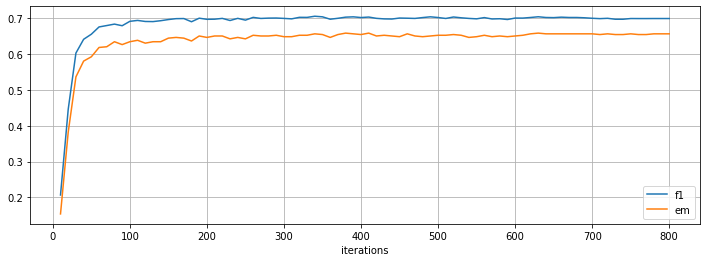

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plot_x = [int(res[0].split('-')[1]) for res in results]
plot_y = [(res[1]['f1'], res[1]['em']) for res in results]

plt.figure(figsize=(12,4))
plt.grid(True)
plots = plt.plot(plot_x, plot_y)

plt.xlabel('iterations')

plt.legend(plots, ('f1', 'em'), loc='best')
plt.savefig("result.pdf")  